In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
import ast
from tabulate import tabulate
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
class HMM:
    def __init__(self, states, observations):
        """
        The initialization of the HMM class with states, observations, and probability matrices has been done.
        The use of dictionaries (state_index and observation_index) for indexing states and observations avoids potential indexing errors.
        """
        self.states = states
        self.observations = observations
        self.start_probabilities = np.zeros(len(states))
        self.transition_probabilities = np.zeros((len(states), len(states)))
        self.emission_probabilities = np.zeros((len(states), len(observations)))

        self.state_index = {state: i for i, state in enumerate(states)}
        self.observation_index = {obs: i for i, obs in enumerate(observations)}

    def compute_start_probabilities(self, sequences):
        """
        The computation of start probabilities based on the first tag of each sequence is appropriate. 
        We have handled cases where the sequence length is 0 to avoid division by zero.
        """
        for sequence in sequences:
            start_state = sequence[0][1] 
            self.start_probabilities[self.state_index[start_state]] += 1
        self.start_probabilities /= np.sum(self.start_probabilities)

    def compute_transition_probabilities(self, sequences):
        """
        The computation of transition probabilities between states is implemented correctly. 
        We have handled cases where the sequence length is 0 to avoid division by zero.
        """
        for sequence in sequences:
            for i in range(len(sequence) - 1):
                current_state = sequence[i][1]
                next_state = sequence[i + 1][1]
                self.transition_probabilities[self.state_index[current_state], self.state_index[next_state]] += 1

        for i in range(len(self.states)):
            if(np.sum(self.transition_probabilities[i])==0):
                continue
            self.transition_probabilities[i] /= np.sum(self.transition_probabilities[i])

    def compute_emission_probabilities(self, sequences):
        """
        The computation of emission probabilities from states to observations is well-implemented. 
        We have handled cases where the sequence length is 0 to avoid division by zero.
        """
        for sequence in sequences:
            for token, state in sequence:
                token_index = self.observation_index[token]
                self.emission_probabilities[self.state_index[state], token_index] += 1

        for i in range(len(self.states)):
            if(np.sum(self.emission_probabilities[i]) == 0):
                print("No emission probability for state: ", self.states[i])
                # Handle unseen words by assigning equal emission probabilities
                self.emission_probabilities[i] = 0
            else:
                self.emission_probabilities[i] /= np.sum(self.emission_probabilities[i])

    def viterbi_algorithm(self, obs):
        """
        The Viterbi algorithm is correctly implemented with the necessary tables for probabilities and backpointers. 
        The logic for finding the best path is accurate.
        We have handled the case when an out of vocabulary word is encountered.
        """
        viterbi_table = [[0.0 for _ in range(len(self.states))] for _ in range(len(obs))]
        backpointer = [[0 for _ in range(len(self.states))] for _ in range(len(obs))]

        for t in range(len(obs)):
            for s in range(len(self.states)):
                if t == 0:
                    if(self.emission_probabilities[s][obs[t]] == 0):
                        self.emission_probabilities[s][obs[t]] = 1e-4

                    viterbi_table[t][s] = self.start_probabilities[s] * self.emission_probabilities[s][obs[t]]
                else:
                    max_prob = -1
                    max_backpointer = -1

                    for s_prime in range(len(self.states)):
                        if(self.emission_probabilities[s][obs[t]] == 0):
                            self.emission_probabilities[s][obs[t]] = 1 / (len(self.observations) + 1)

                        prob = viterbi_table[t-1][s_prime] * self.transition_probabilities[s_prime][s] * self.emission_probabilities[s][obs[t]]
                        if prob > max_prob:
                            max_prob = prob
                            max_backpointer = s_prime

                    viterbi_table[t][s] = max_prob
                    backpointer[t][s] = max_backpointer

        best_path_pointer = max(range(len(self.states)), key=lambda s: viterbi_table[-1][s])
        best_path = [best_path_pointer]
        for t in range(len(obs)-1, 0, -1):
            best_path.insert(0, backpointer[t][best_path[0]])

        return best_path

In [3]:
# df_train_combined = pd.read_csv('../combined_train.csv' , converters={'tokens': ast.literal_eval, 'ner_tags': ast.literal_eval})
test_combined = pd.read_csv('../combined_test.csv')

In [4]:
file_path = '../combined_train.csv'
df_train_combined = pd.read_csv(file_path, converters={'tokens': ast.literal_eval, 'ner_tags': ast.literal_eval})

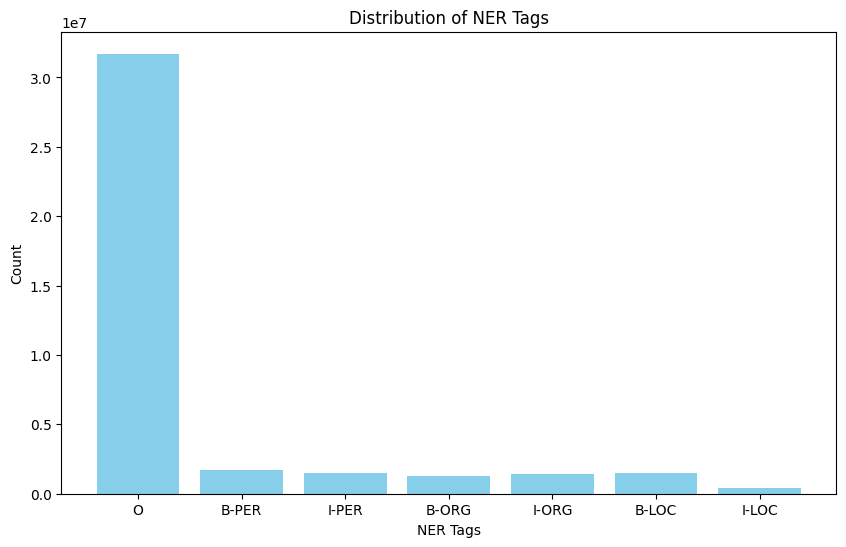

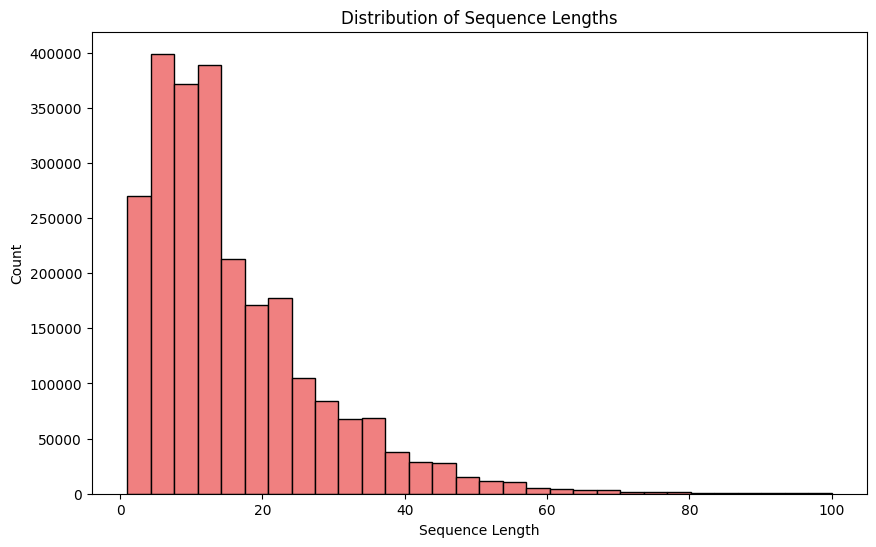

Number of unique tokens: 1517842


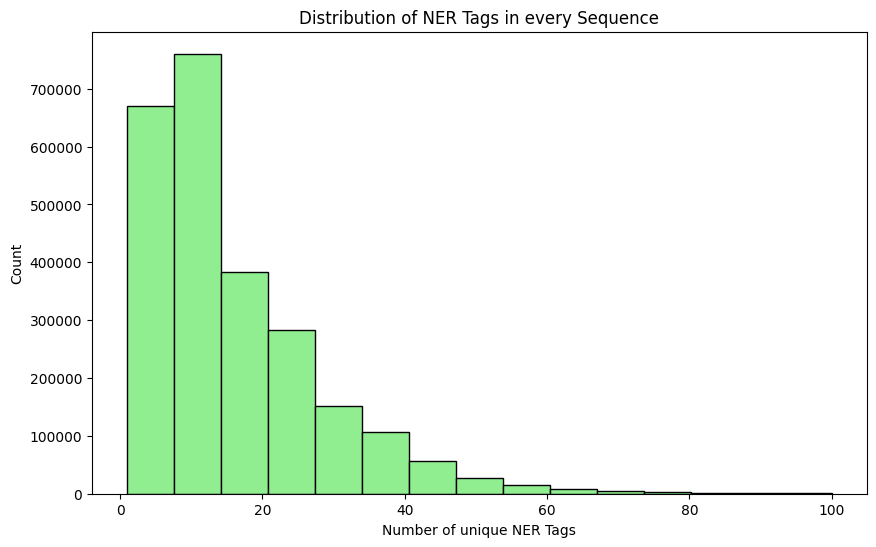

In [5]:
ner_distribution = df_train_combined['ner_tags'].explode().value_counts().sort_index()
ner_tags = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

plt.figure(figsize=(10, 6))
plt.bar(ner_tags, ner_distribution, color='skyblue')
plt.title('Distribution of NER Tags')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.show()

df_train_combined['sequence_length'] = df_train_combined['tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df_train_combined['sequence_length'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

unique_tokens_distribution = df_train_combined['tokens'].explode().nunique()
print(f"Number of unique tokens: {unique_tokens_distribution}")

ner_per_sequence_distribution = df_train_combined['ner_tags'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(ner_per_sequence_distribution, bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of NER Tags in every Sequence')
plt.xlabel('Number of unique NER Tags')
plt.ylabel('Count')
plt.show()

In [6]:
def train_hmm(hmm_model, sequences):
    hmm_model.compute_start_probabilities(sequences)
    hmm_model.compute_transition_probabilities(sequences)
    hmm_model.compute_emission_probabilities(sequences)

In [7]:
def get_hmm_model(train_df, test_d):
    train_data = [(row['tokens'], row['ner_tags']) for _, row in train_df.iterrows()]
    unique_tags = set(tag for _, tags in train_data for tag in tags)

    states = list(unique_tags)
    sequences = [list(zip(tokens, tags)) for tokens, tags in train_data]

    unique_tokens = set()
    for sequence in sequences:
        for token, _ in sequence:
            unique_tokens.add(token)

    unique_tokens.add('UNK')
    unique_tokens_list = list(unique_tokens)

    hmm_model = HMM(states, unique_tokens_list)

    train_hmm(hmm_model, sequences)

    test_tokens = test_d['tokens']
    test_ner_tags = test_d['ner_tags']

    N_test = len(test_tokens)

    return hmm_model, N_test, test_tokens, test_ner_tags, states

## Training the HMM Model

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from seaborn import heatmap
import seaborn as sns

def compute_metrics(true_tags, predicted_tags, accuracy, states):
    # Exclude state 0 (OTHER) from the list of states
    states = [state for state in states if state != 0]

    print("\nOverall Metrics (excluding 'OTHER'):")
    print("Accuracy:", accuracy)
    print(classification_report(true_tags, predicted_tags, zero_division=1, labels=states))

    print("\nPer-State Metrics (excluding 'OTHER'):")
    per_state_report = classification_report(true_tags, predicted_tags, labels=states, output_dict=True, zero_division=1)

    precision_values = [per_state_report[str(state)]['precision'] for state in states]
    recall_values = [per_state_report[str(state)]['recall'] for state in states]
    f1_score_values = [per_state_report[str(state)]['f1-score'] for state in states]
    support_values = [per_state_report[str(state)]['support'] for state in states]
    state_accuracy_values = [
        sum(1 for true, pred in zip(true_tags, predicted_tags) if true == state and pred == state) / true_tags.count(state) if true_tags.count(state) > 0 else 0
        for state in states
    ]

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    fig.suptitle("Metrics Comparison for Different Entity Types (excluding 'OTHER')", fontsize=16)

    axes[0, 0].bar(states, precision_values, color='skyblue')
    axes[0, 0].set_title("Precision")
    axes[0, 0].set_ylabel("Score")

    axes[0, 1].bar(states, recall_values, color='lightcoral')
    axes[0, 1].set_title("Recall")
    axes[0, 1].set_ylabel("Score")

    axes[1, 0].bar(states, f1_score_values, color='lightgreen')
    axes[1, 0].set_title("F1-Score")
    axes[1, 0].set_ylabel("Score")

    support_bars = axes[1, 1].bar(states, support_values, color='gold')
    axes[1, 1].set_title("Support")
    axes[1, 1].set_ylabel("Count")

    for bar, support_value in zip(support_bars, support_values):
        axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(support_value), ha='center', va='bottom')

    axes[2, 0].bar(states, state_accuracy_values, color='orchid')
    axes[2, 0].set_title("State-wise Accuracy")
    axes[2, 0].set_ylabel("Accuracy")

    fig.delaxes(axes[2, 1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nConfusion Matrix (excluding 'OTHER'):")
    plt.figure(figsize=(16, 10))
    conf_matrix = confusion_matrix(true_tags, predicted_tags, labels=states)
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=states, yticklabels=states)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (excluding 'OTHER')")
    plt.show()

In [9]:
def plot_misclassification_rates(states, true_tags, predicted_tags):
    misclassification_rates = {state: 0 for state in states}
    
    for true_tag, predicted_tag in zip(true_tags, predicted_tags):
        if true_tag != predicted_tag:
            misclassification_rates[true_tag] += 1

    misclassification_rates = {
        state: misclassification_rates[state] / true_tags.count(state) if true_tags.count(state) > 0 else 0
        for state in states
    }    
    
    sorted_states = sorted(states, key=lambda state: misclassification_rates[state], reverse=True)

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_states, [misclassification_rates[state] for state in sorted_states], color='coral')
    plt.xlabel("Entity Types")
    plt.ylabel("Misclassification Rate")
    plt.title("Misclassification Rates for Different Entity Types")
    plt.show()

In [10]:
def evaluate_model(hmm_model, test_ner_tags, test_tokens, N_test, states):
    true_tags_all = []
    predicted_tags_all = []

    correct = 0
    total = 0
    for idx in range(N_test):
        tags = eval(test_ner_tags[idx])
        observations = [obs for obs in eval(test_tokens[idx])]
        if len(observations) == 0:
            continue
        
        observed_tokens = [tok for tok in eval(test_ner_tags[idx])]

        observation_indices = [
            hmm_model.observation_index[obs] if obs in hmm_model.observation_index else hmm_model.observation_index['UNK']
            for obs in observations
        ]
        
        predicted_tags = hmm_model.viterbi_algorithm(observation_indices)
        
        true_tags_all.extend(tags)
        predicted_tags_all.extend([states[tag] for tag in predicted_tags])
        
        for i in range(len(predicted_tags)):
            if predicted_tags[i] == observed_tokens[i]:
                correct += 1

        total += len(observations)
        
    accuracy = correct / total

    compute_metrics(true_tags_all, predicted_tags_all, accuracy, states)
    plot_misclassification_rates(states, true_tags_all, predicted_tags_all)

## Evaluating the HMM Model, plotting state wise metrics like accuracy, precision, recall and f1-score and plotting the misclassification rate for each state in Multi-lingual Dataset

In [ ]:
hmm_model_combined, N_test_combined, test_tokens_combined, test_ner_tags_combined, states  = get_hmm_model(df_train_combined, test_combined)


Overall Metrics (excluding 'OTHER'):
Accuracy: 0.8697657505932788
              precision    recall  f1-score   support

           1       0.77      0.71      0.74      2556
           2       0.75      0.81      0.78      2261
           3       0.59      0.55      0.57      1514
           4       0.39      0.71      0.50      1661
           5       0.68      0.65      0.67      2135
           6       0.35      0.66      0.46       495

   micro avg       0.60      0.69      0.65     10622
   macro avg       0.59      0.68      0.62     10622
weighted avg       0.64      0.69      0.66     10622


Per-State Metrics (excluding 'OTHER'):


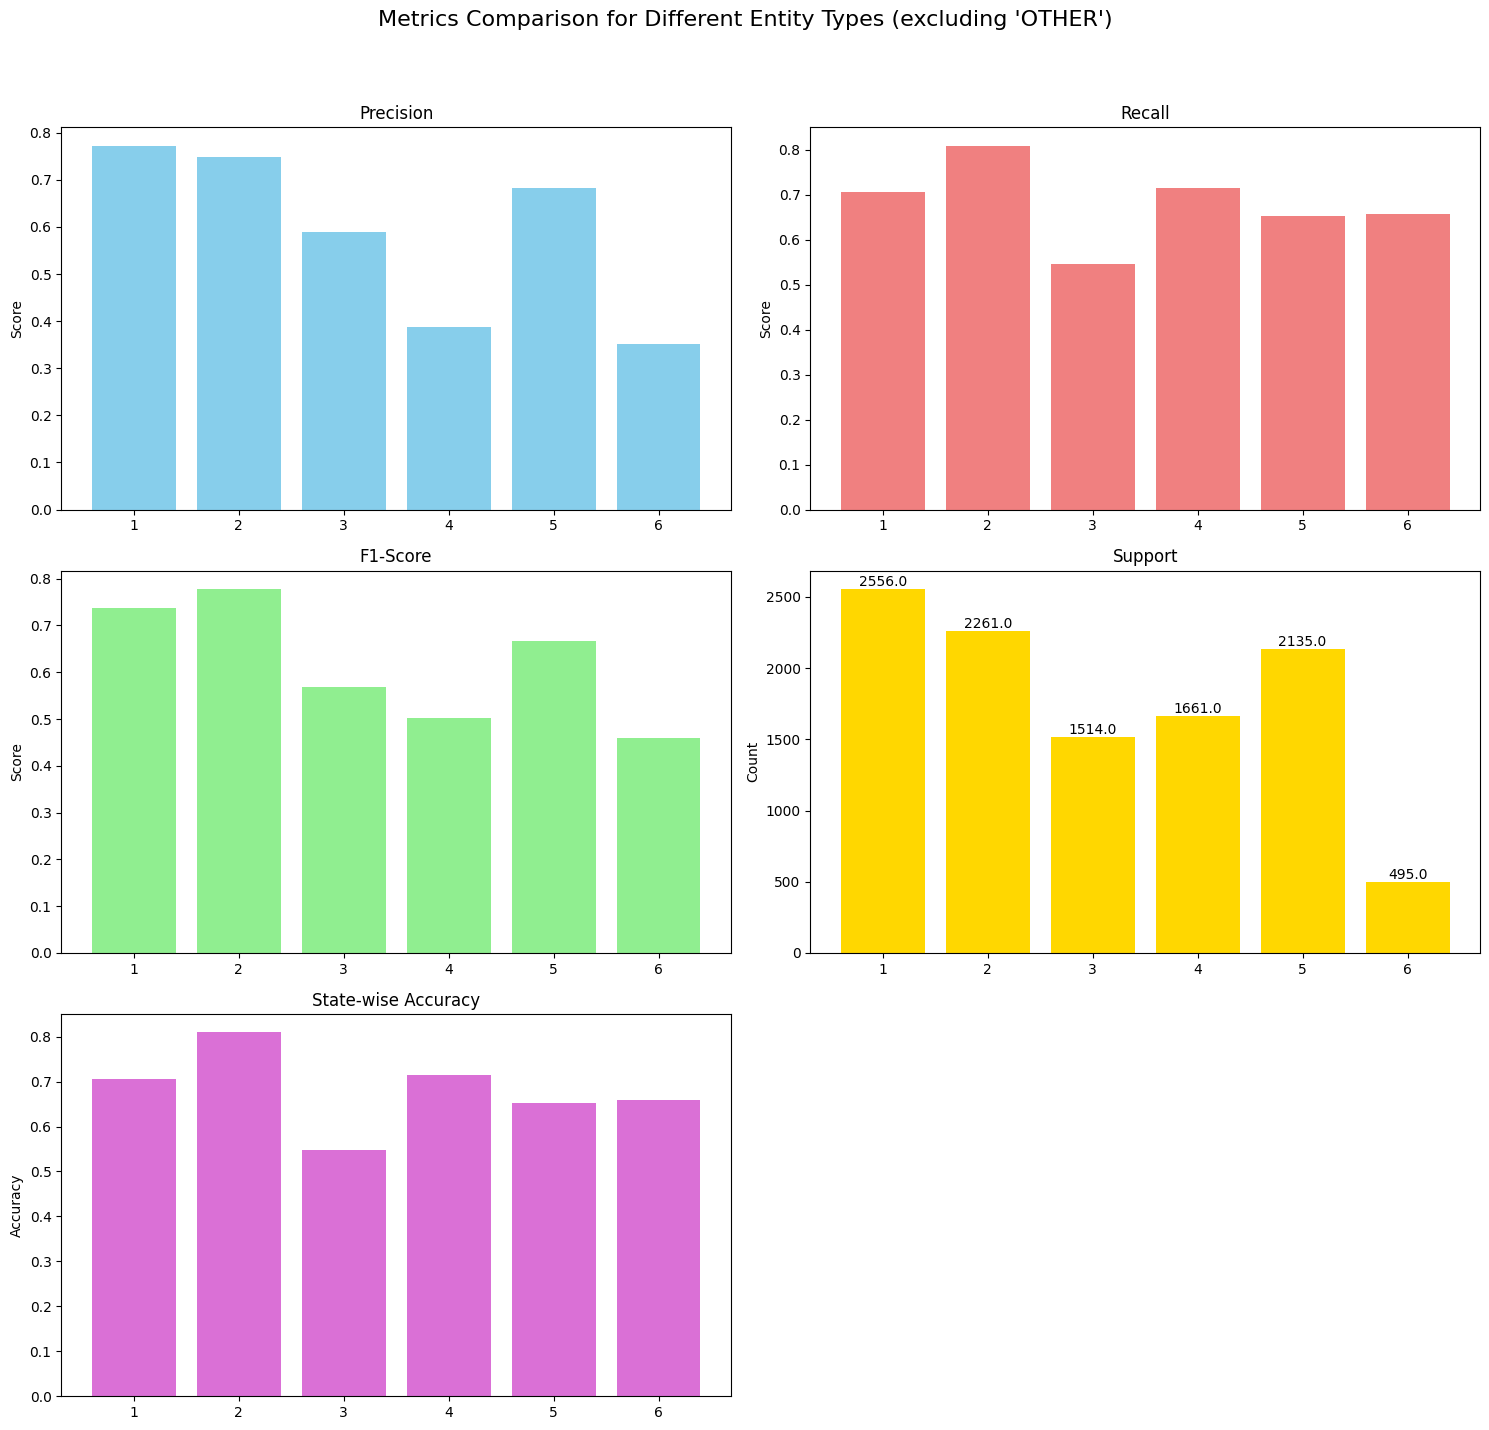


Confusion Matrix (excluding 'OTHER'):


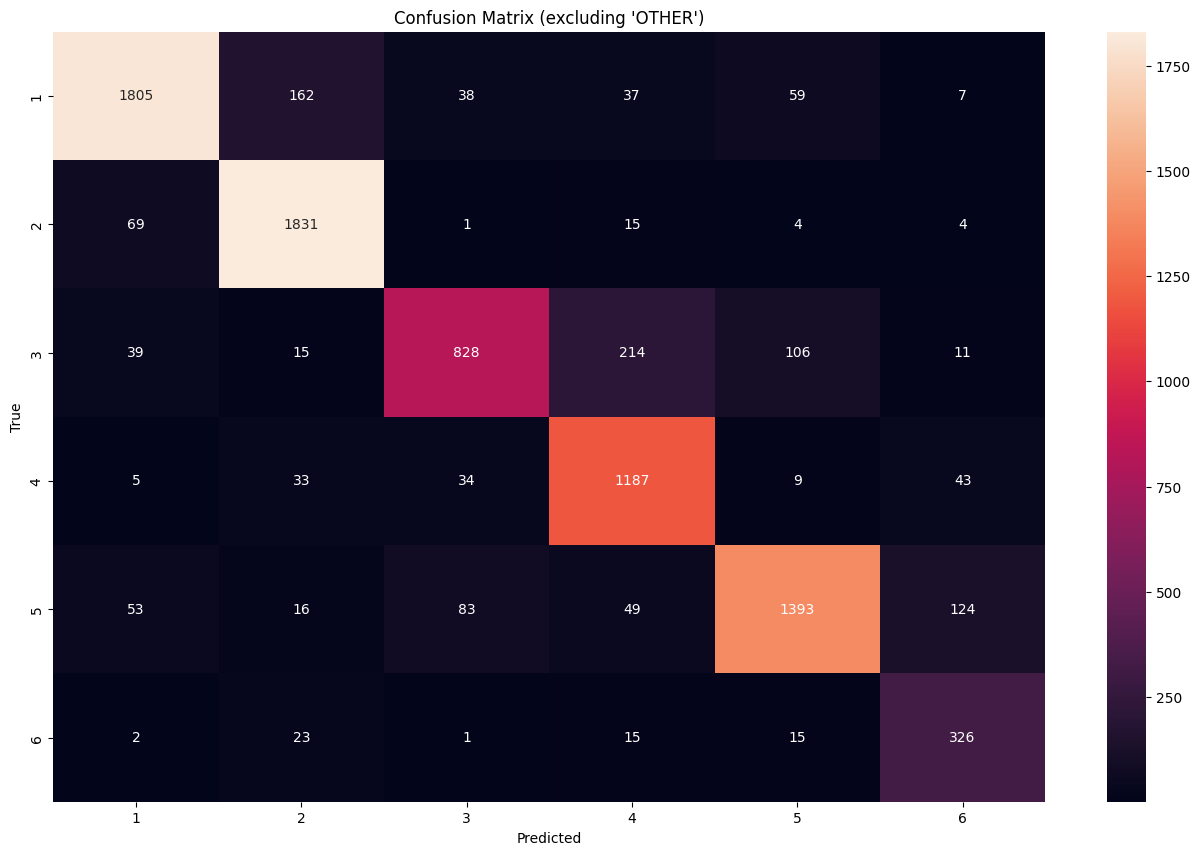

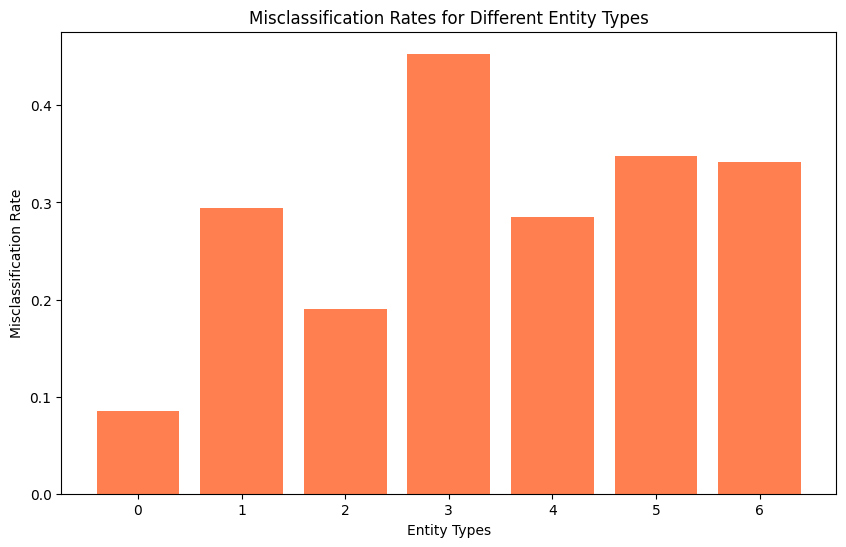

In [13]:
evaluate_model(hmm_model_combined, test_ner_tags_combined, test_tokens_combined, N_test_combined, np.arange(len(ner_tags)))

# For Cross-Domain data sets:

## Science Dataset

In [60]:
df_train_science = pd.read_csv('../cross_domain/science/science_train.csv' , converters={'tokens': ast.literal_eval, 'ner_tags': ast.literal_eval})
test_science = pd.read_csv('../cross_domain/science/science_test.csv')

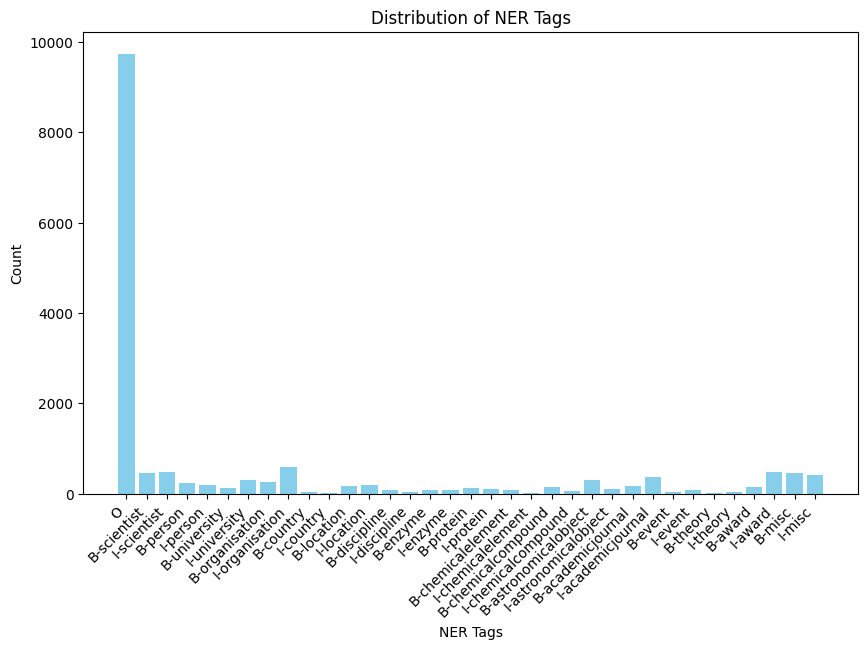

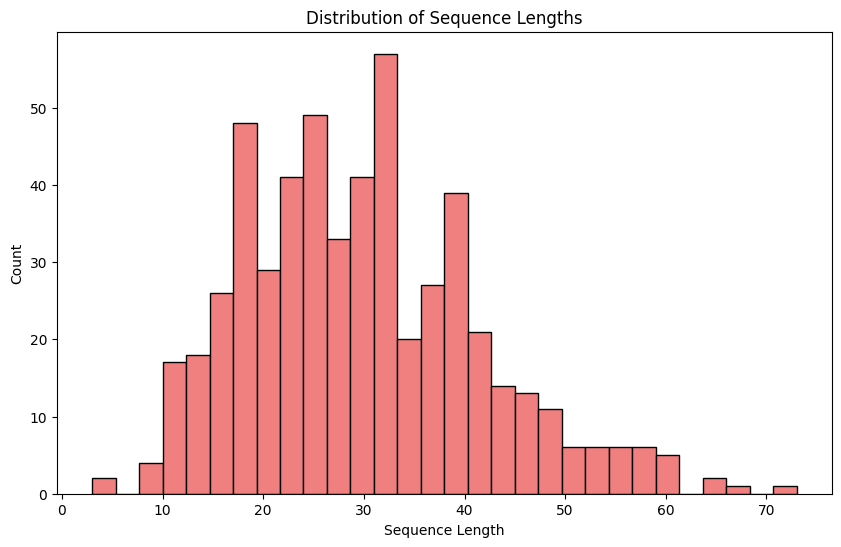

Number of unique tokens: 4139


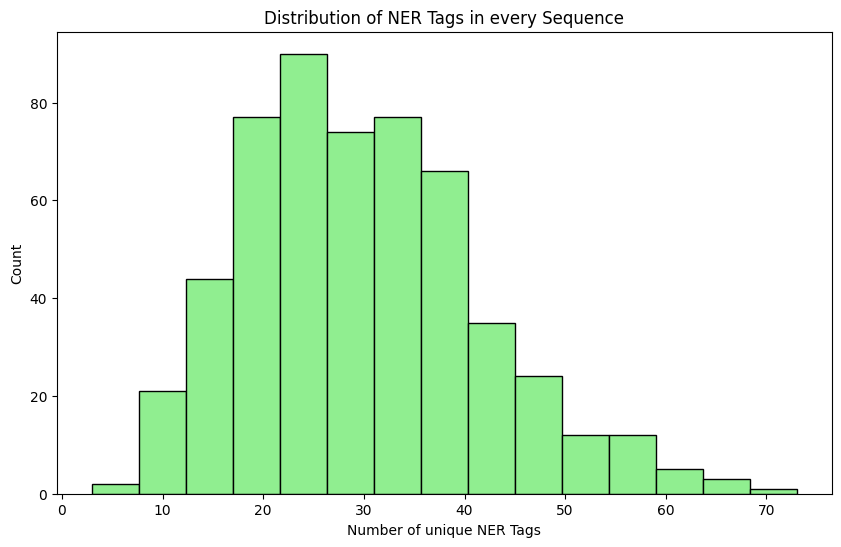

In [61]:
ner_tags = ['O', 'B-scientist', 'I-scientist', 'B-person', 'I-person', 'B-university', 'I-university', 'B-organisation', 'I-organisation', 'B-country', 'I-country', 'B-location', 'I-location', 'B-discipline', 'I-discipline', 'B-enzyme', 'I-enzyme', 'B-protein', 'I-protein', 'B-chemicalelement', 'I-chemicalelement', 'B-chemicalcompound', 'I-chemicalcompound', 'B-astronomicalobject', 'I-astronomicalobject', 'B-academicjournal', 'I-academicjournal', 'B-event', 'I-event', 'B-theory', 'I-theory', 'B-award', 'I-award', 'B-misc', 'I-misc']
ner_distribution_dict = {i: 0 for i in range(len(ner_tags))}

ner_distribution = df_train_science['ner_tags'].explode().value_counts().sort_index()
ner_distribution_dict.update(ner_distribution)
ner_distribution = pd.Series(ner_distribution_dict)

plt.figure(figsize=(10, 6))
plt.bar(ner_tags, ner_distribution, color='skyblue')
plt.title('Distribution of NER Tags')
plt.xticks(rotation=45, ha='right')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.show()

df_train_science['sequence_length'] = df_train_science['tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df_train_science['sequence_length'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

unique_tokens_distribution = df_train_science['tokens'].explode().nunique()
print(f"Number of unique tokens: {unique_tokens_distribution}")

ner_per_sequence_distribution = df_train_science['ner_tags'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(ner_per_sequence_distribution, bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of NER Tags in every Sequence')
plt.xlabel('Number of unique NER Tags')
plt.ylabel('Count')
plt.show()


Overall Metrics (excluding 'OTHER'):
Accuracy: 0.7215338245144005
              precision    recall  f1-score   support

           1       0.81      0.48      0.60       120
           2       0.82      0.55      0.66       123
           3       1.00      0.09      0.16        91
           4       1.00      0.13      0.23        68
           5       0.50      0.39      0.44        54
           6       0.47      0.58      0.52       115
           7       0.56      0.35      0.43       113
           8       0.60      0.58      0.59       306
           9       0.40      0.22      0.29         9
          10       1.00      0.50      0.67         2
          11       0.52      0.17      0.26        63
          12       0.47      0.30      0.37        53
          13       0.20      0.09      0.13        22
          14       0.14      0.10      0.12        10
          15       0.81      0.62      0.70        21
          16       0.87      0.62      0.72        21
          17  

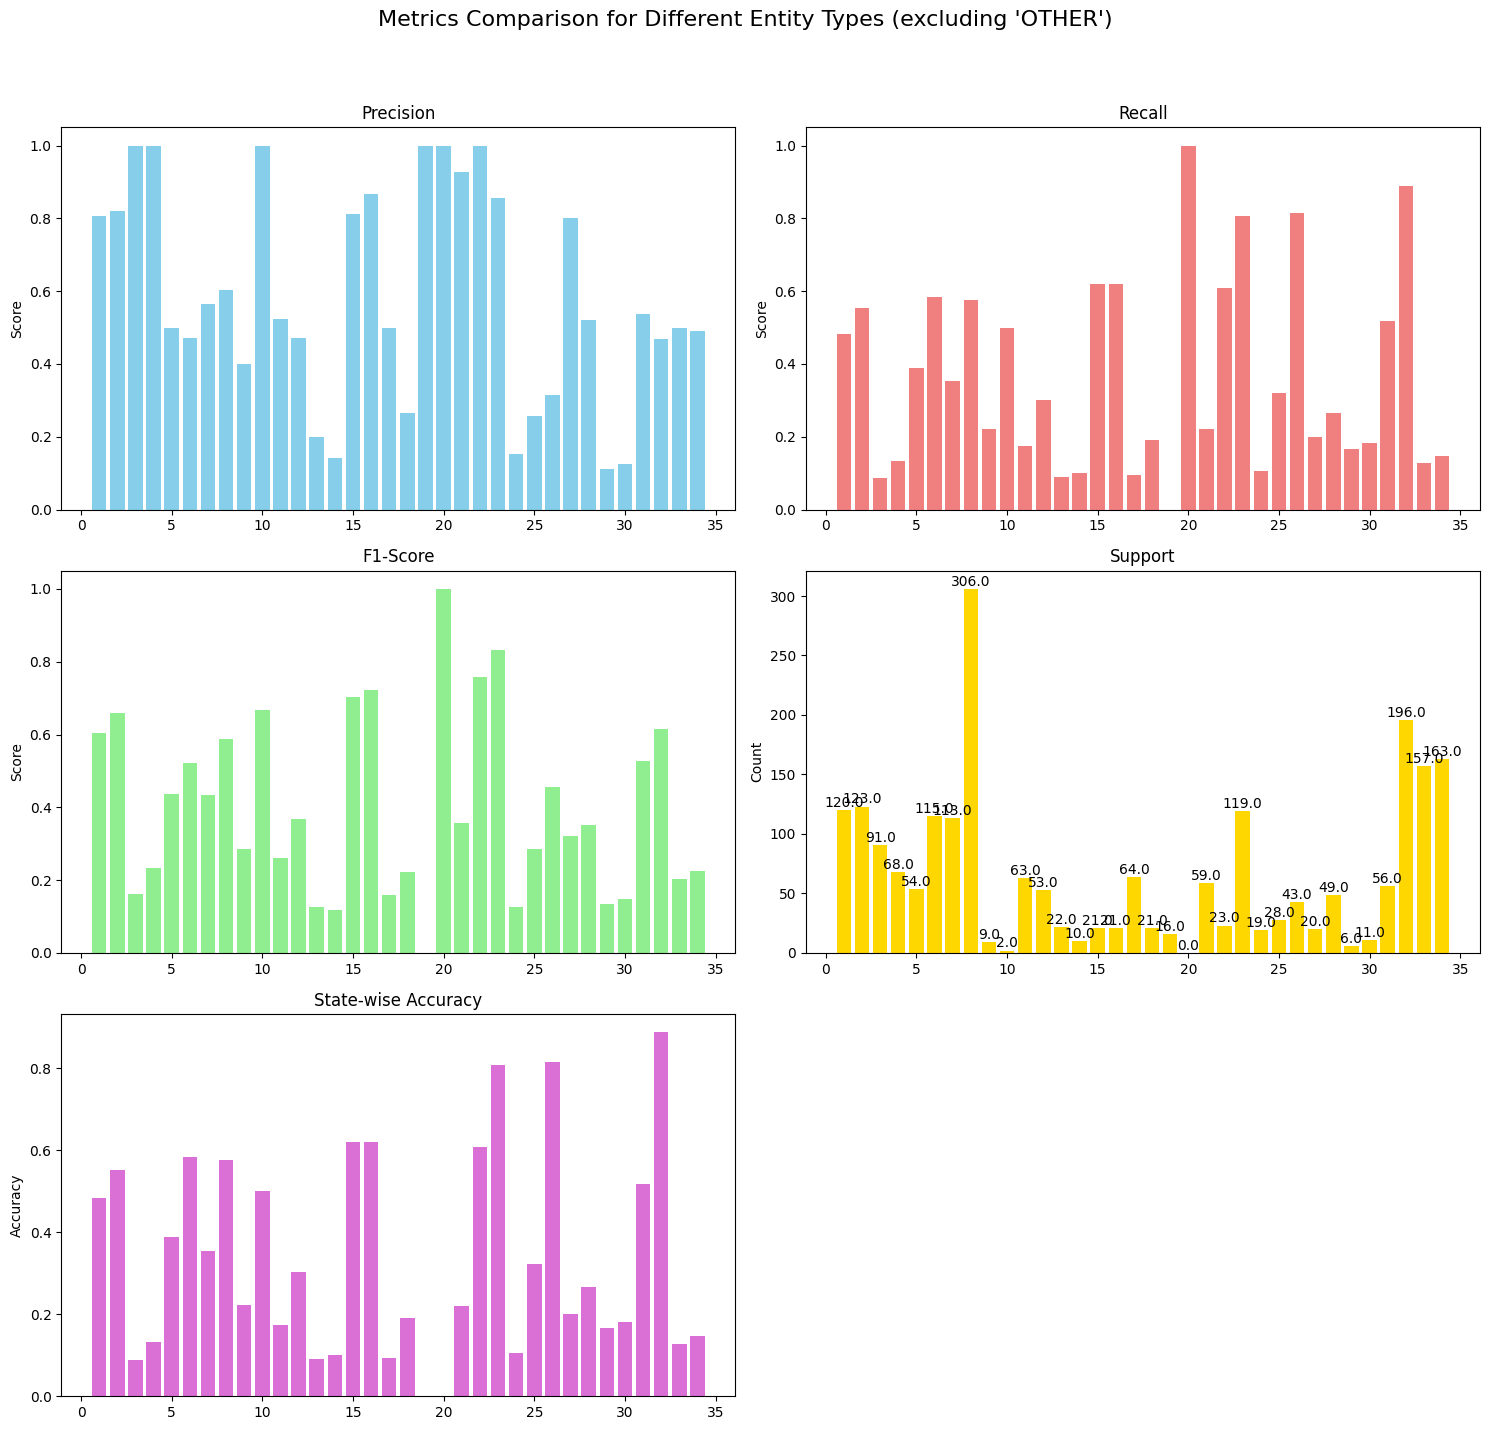


Confusion Matrix (excluding 'OTHER'):


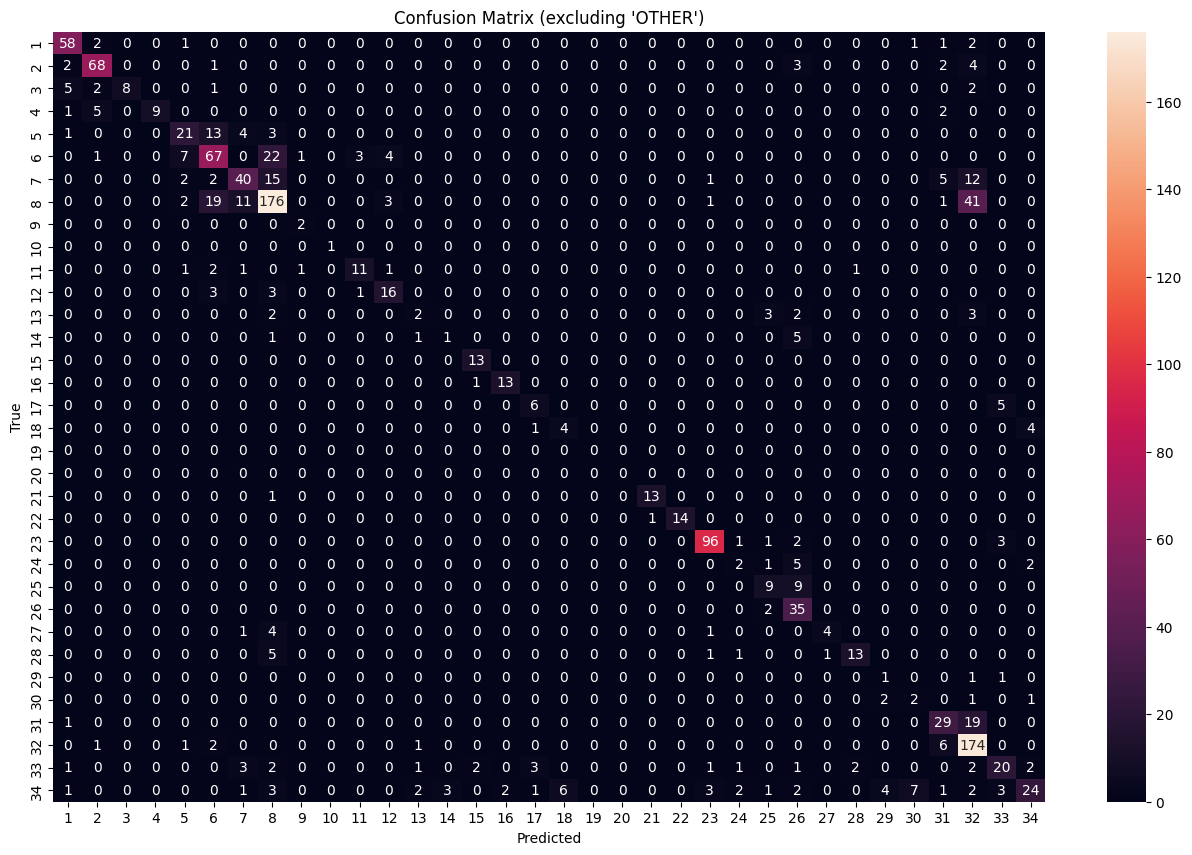

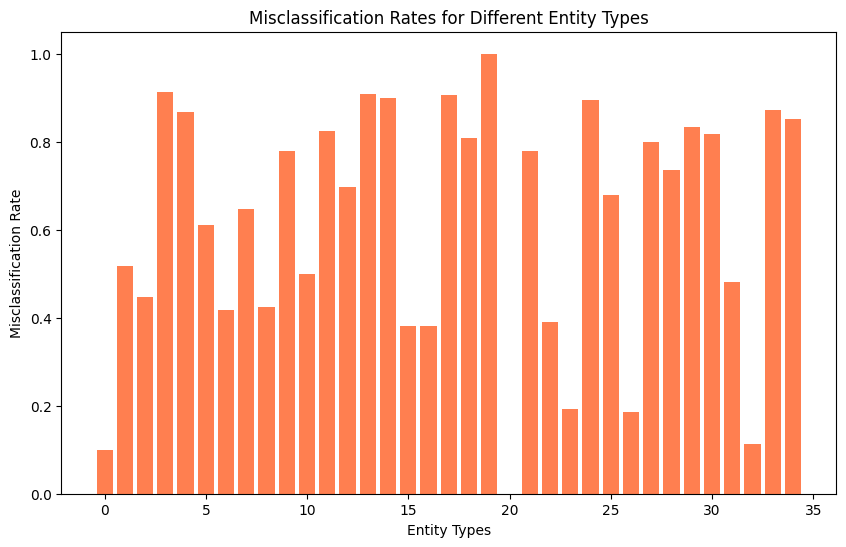

In [62]:
hmm_model_science, N_test_science, test_tokens_science, test_ner_tags_science, states  = get_hmm_model(df_train_science, test_science)
evaluate_model(hmm_model_science, test_ner_tags_science, test_tokens_science, N_test_science, np.arange(len(ner_tags)))

## Literature Data

In [57]:
df_train_lit = pd.read_csv('../cross_domain/literature/literature_train.csv' , converters={'tokens': ast.literal_eval, 'ner_tags': ast.literal_eval})
test_lit = pd.read_csv('../cross_domain/literature/literature_test.csv')

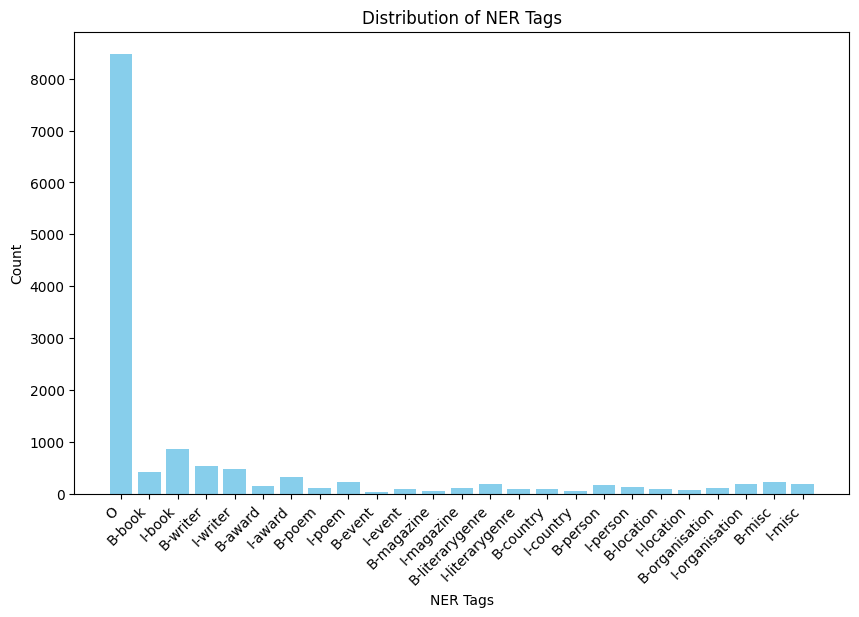

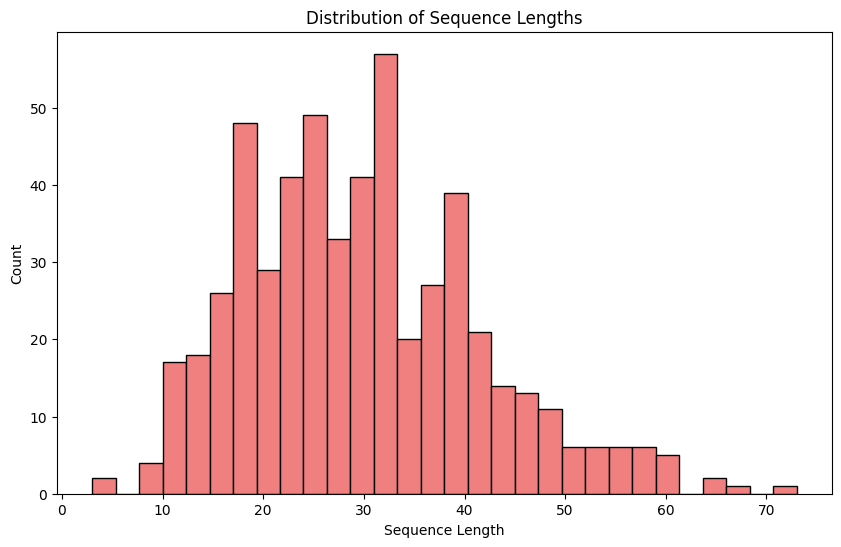

Number of unique tokens: 4139


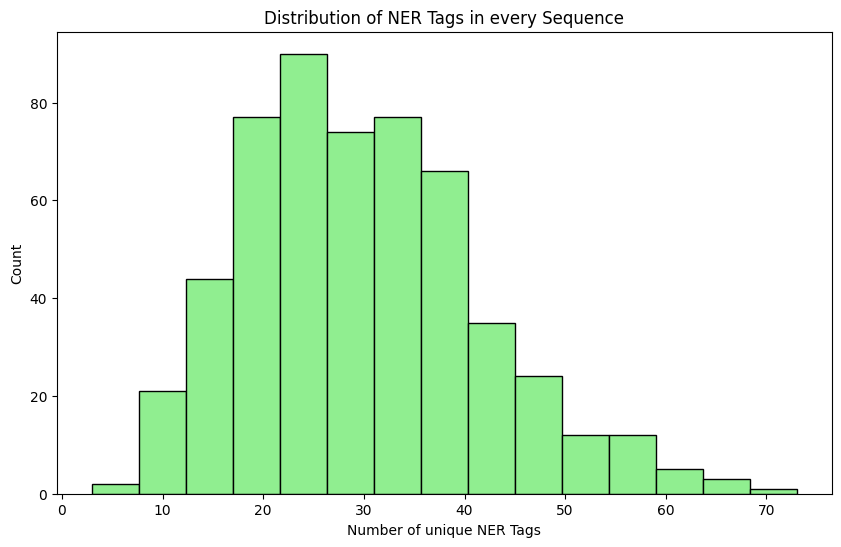

In [58]:
ner_tags = ["O", "B-book", "I-book", "B-writer", "I-writer", "B-award", "I-award", "B-poem", "I-poem", "B-event", "I-event", "B-magazine", "I-magazine", "B-literarygenre", "I-literarygenre", 'B-country', 'I-country', "B-person", "I-person", "B-location", "I-location", 'B-organisation', 'I-organisation', 'B-misc', 'I-misc']
ner_distribution_dict = {i: 0 for i in range(len(ner_tags))}

ner_distribution = df_train_lit['ner_tags'].explode().value_counts().sort_index()
ner_distribution_dict.update(ner_distribution)
ner_distribution = pd.Series(ner_distribution_dict)


plt.figure(figsize=(10, 6))
plt.bar(ner_tags, ner_distribution, color='skyblue')
plt.title('Distribution of NER Tags')
plt.xticks(rotation=45, ha='right')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.show()

df_train_science['sequence_length'] = df_train_science['tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df_train_science['sequence_length'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

unique_tokens_distribution = df_train_science['tokens'].explode().nunique()
print(f"Number of unique tokens: {unique_tokens_distribution}")

ner_per_sequence_distribution = df_train_science['ner_tags'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(ner_per_sequence_distribution, bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of NER Tags in every Sequence')
plt.xlabel('Number of unique NER Tags')
plt.ylabel('Count')
plt.show()


Overall Metrics (excluding 'OTHER'):
Accuracy: 0.6918476550204595
              precision    recall  f1-score   support

           1       0.40      0.19      0.26        89
           2       0.46      0.32      0.38       236
           3       0.68      0.26      0.37       124
           4       0.73      0.33      0.45       106
           5       0.76      0.76      0.76        34
           6       0.82      0.78      0.80        76
           7       0.57      0.18      0.27        45
           8       0.59      0.34      0.43        88
           9       0.67      0.40      0.50        10
          10       0.85      0.42      0.56        26
          11       0.53      0.50      0.52        16
          12       0.49      0.71      0.58        24
          13       0.62      0.74      0.68        34
          14       0.56      0.53      0.55        17
          15       0.92      0.48      0.63        25
          16       0.65      0.92      0.76        12
          17  

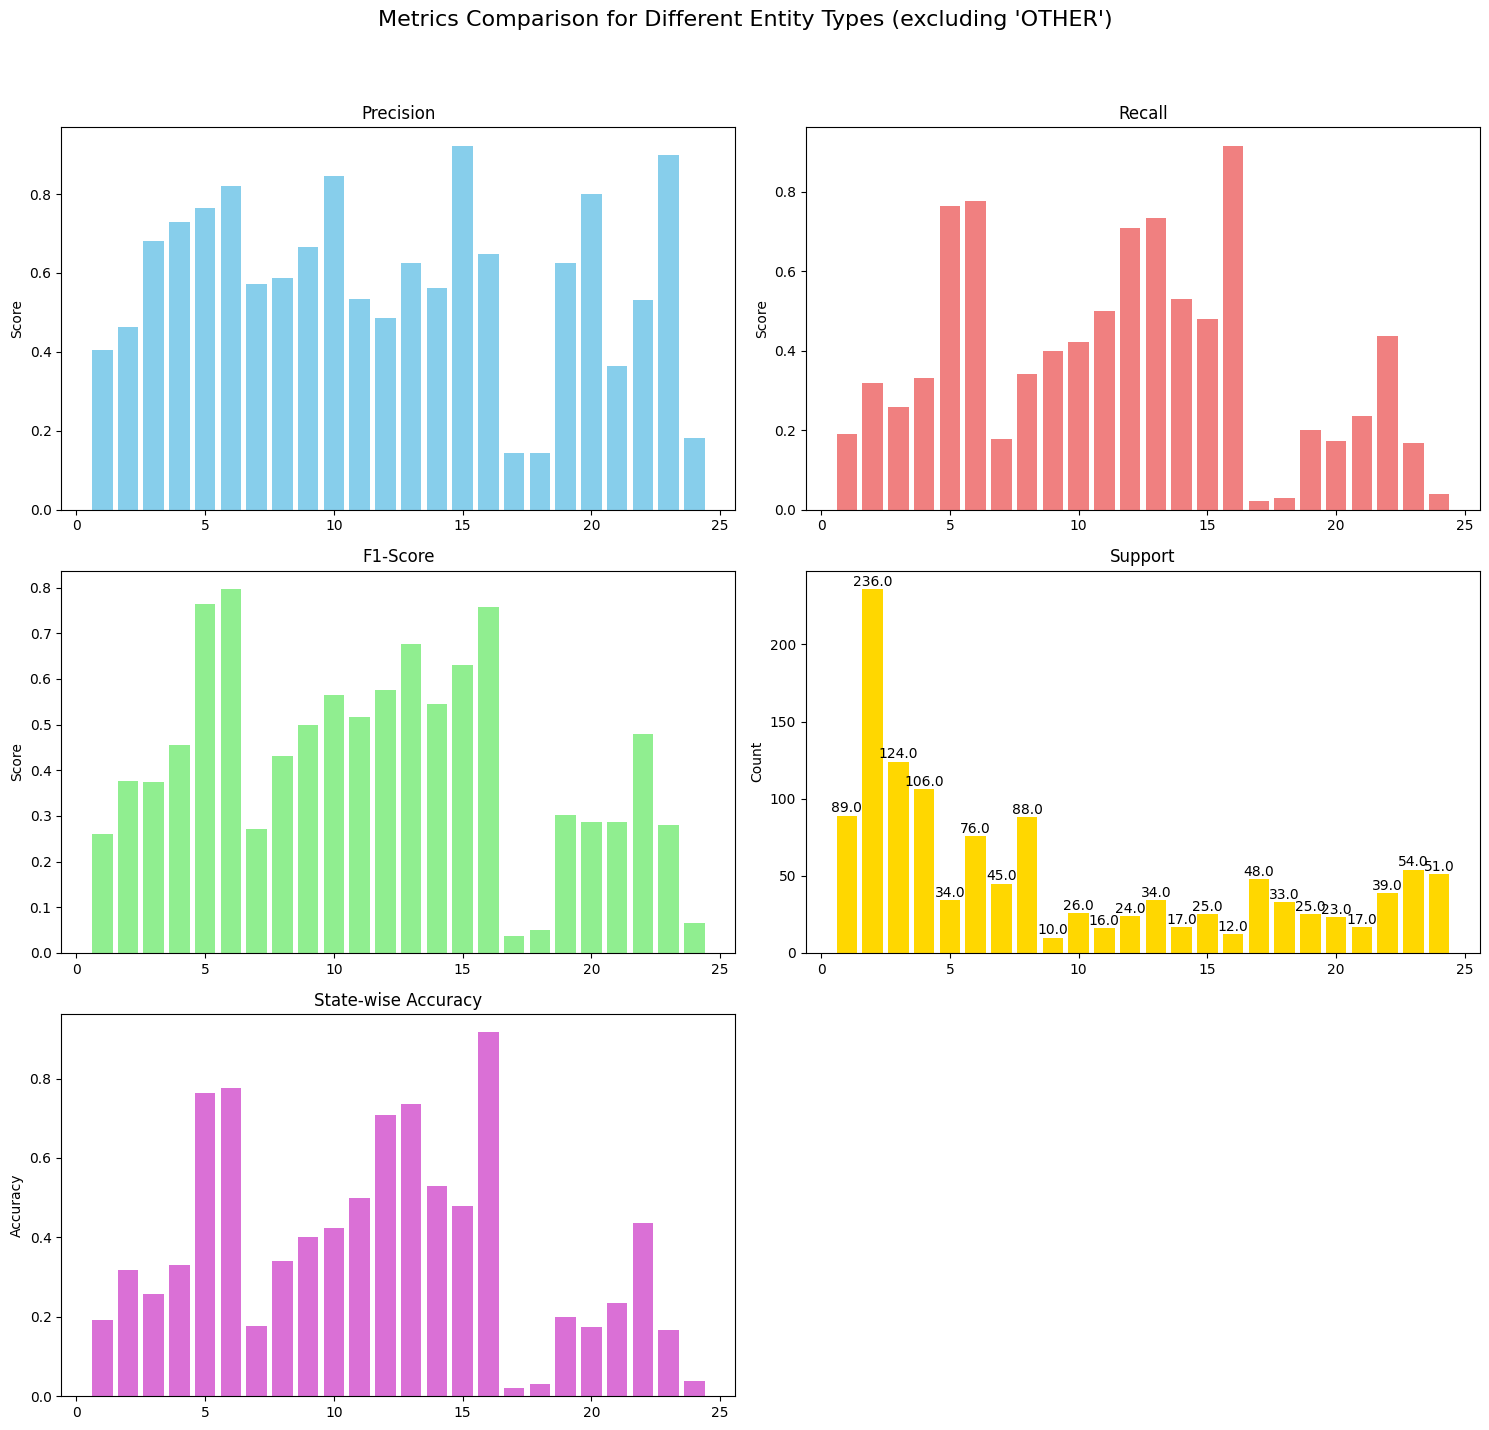


Confusion Matrix (excluding 'OTHER'):


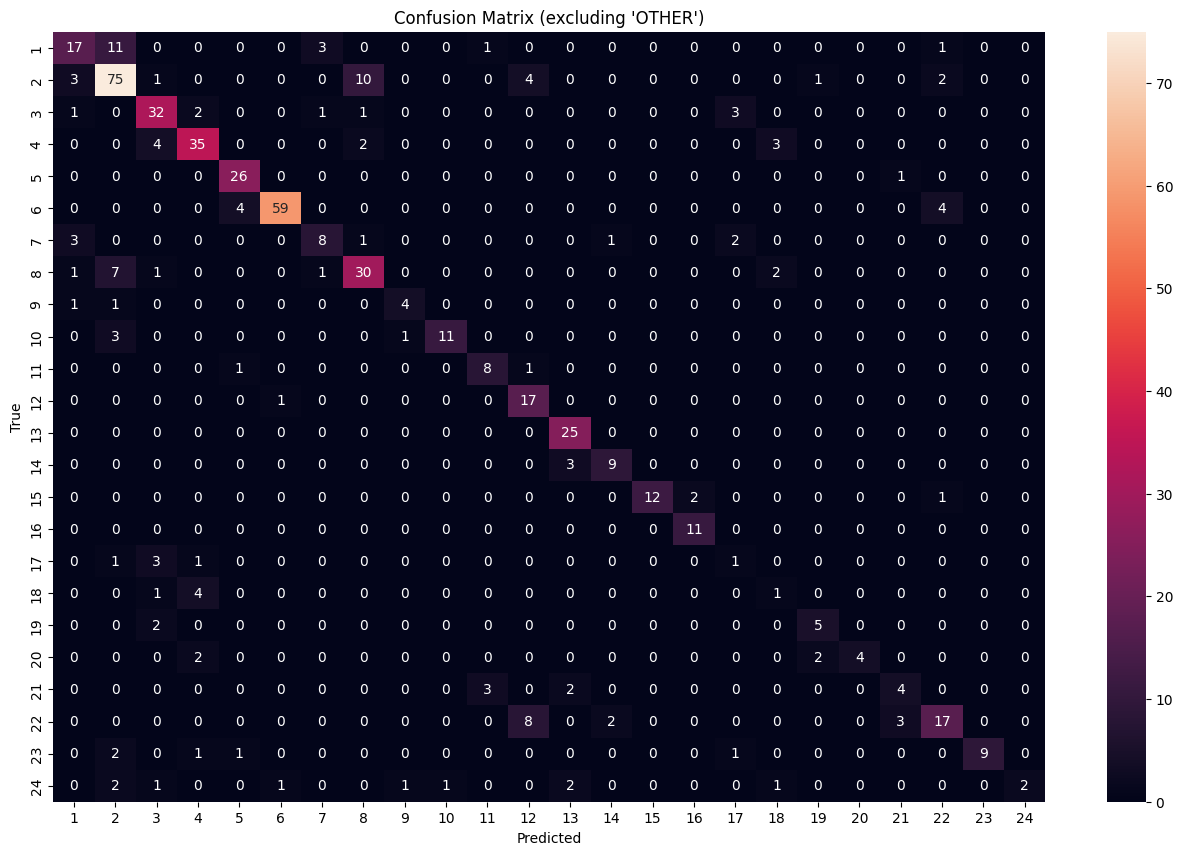

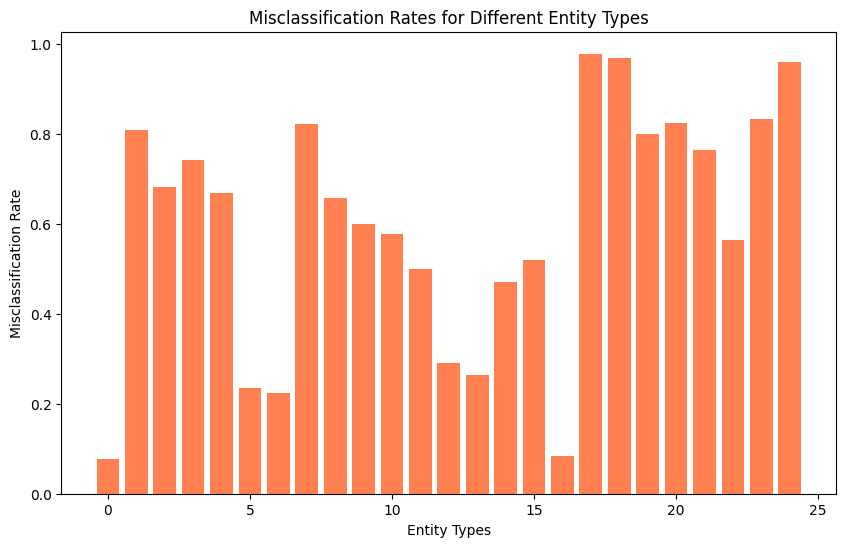

In [59]:
hmm_model_lit, N_test_lit, test_tokens_lit, test_ner_tags_lit, states  = get_hmm_model(df_train_lit, test_lit)
evaluate_model(hmm_model_lit, test_ner_tags_lit, test_tokens_lit, N_test_lit, np.arange(len(ner_tags)))

## AI Data

In [54]:
df_train_ai = pd.read_csv('../cross_domain/ai/ai_train.csv' , converters={'tokens': ast.literal_eval, 'ner_tags': ast.literal_eval})
test_ai = pd.read_csv('../cross_domain/ai/ai_train.csv')

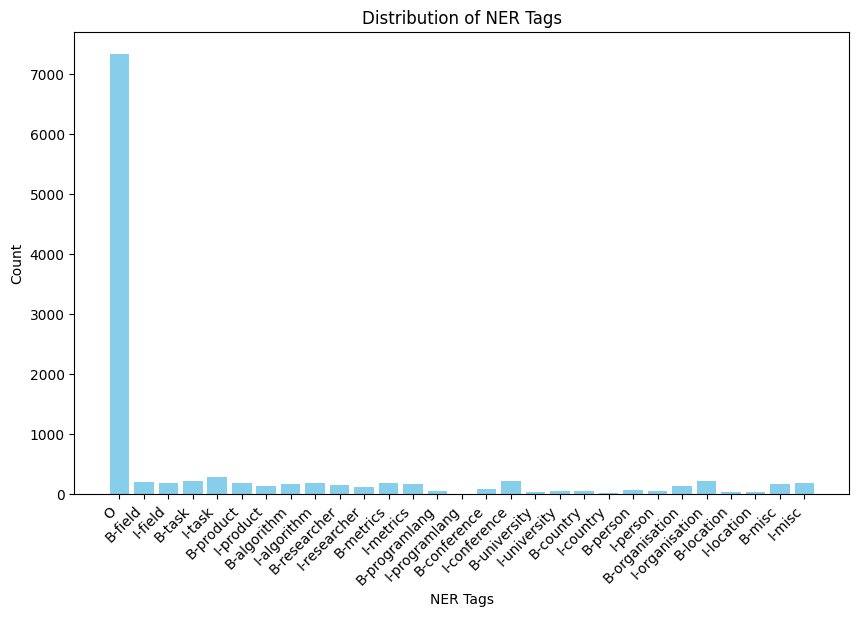

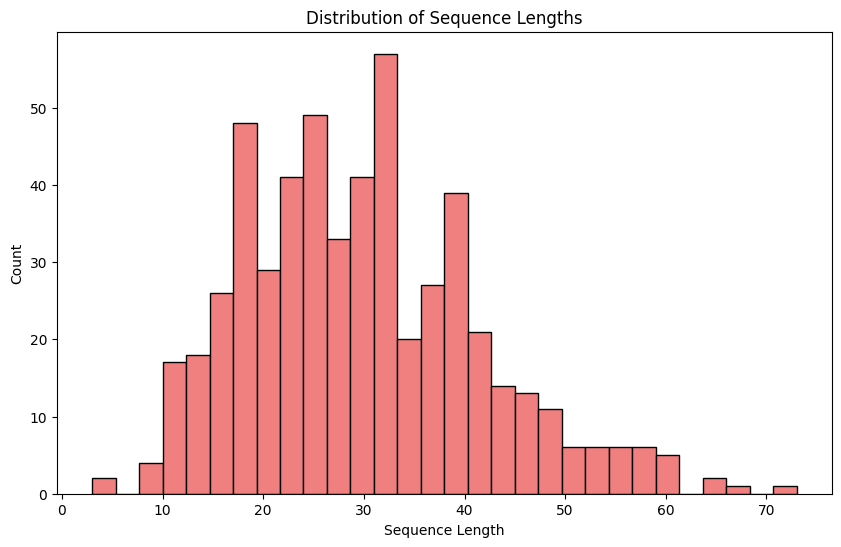

Number of unique tokens: 4139


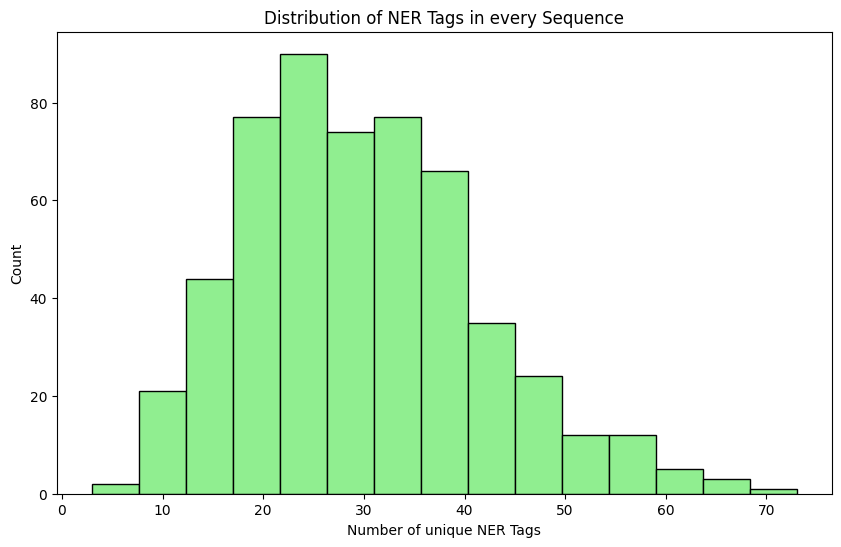

In [55]:
ner_tags = ["O", "B-field", "I-field", "B-task", "I-task", "B-product", "I-product", "B-algorithm", "I-algorithm", "B-researcher", "I-researcher", "B-metrics", "I-metrics", "B-programlang", "I-programlang", "B-conference", "I-conference", "B-university", "I-university", "B-country", "I-country", "B-person", "I-person", "B-organisation", "I-organisation", "B-location", "I-location", "B-misc", "I-misc"]
ner_distribution_dict = {i: 0 for i in range(len(ner_tags))}

ner_distribution = df_train_ai['ner_tags'].explode().value_counts().sort_index()
ner_distribution_dict.update(ner_distribution)
ner_distribution = pd.Series(ner_distribution_dict)


plt.figure(figsize=(10, 6))
plt.bar(ner_tags, ner_distribution, color='skyblue')
plt.title('Distribution of NER Tags')
plt.xticks(rotation=45, ha='right')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.show()

df_train_science['sequence_length'] = df_train_science['tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df_train_science['sequence_length'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

unique_tokens_distribution = df_train_science['tokens'].explode().nunique()
print(f"Number of unique tokens: {unique_tokens_distribution}")

ner_per_sequence_distribution = df_train_science['ner_tags'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(ner_per_sequence_distribution, bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of NER Tags in every Sequence')
plt.xlabel('Number of unique NER Tags')
plt.ylabel('Count')
plt.show()


Overall Metrics (excluding 'OTHER'):
Accuracy: 0.6918476550204595
              precision    recall  f1-score   support

           1       0.40      0.19      0.26        89
           2       0.46      0.32      0.38       236
           3       0.68      0.26      0.37       124
           4       0.73      0.33      0.45       106
           5       0.76      0.76      0.76        34
           6       0.82      0.78      0.80        76
           7       0.57      0.18      0.27        45
           8       0.59      0.34      0.43        88
           9       0.67      0.40      0.50        10
          10       0.85      0.42      0.56        26
          11       0.53      0.50      0.52        16
          12       0.49      0.71      0.58        24
          13       0.62      0.74      0.68        34
          14       0.56      0.53      0.55        17
          15       0.92      0.48      0.63        25
          16       0.65      0.92      0.76        12
          17  

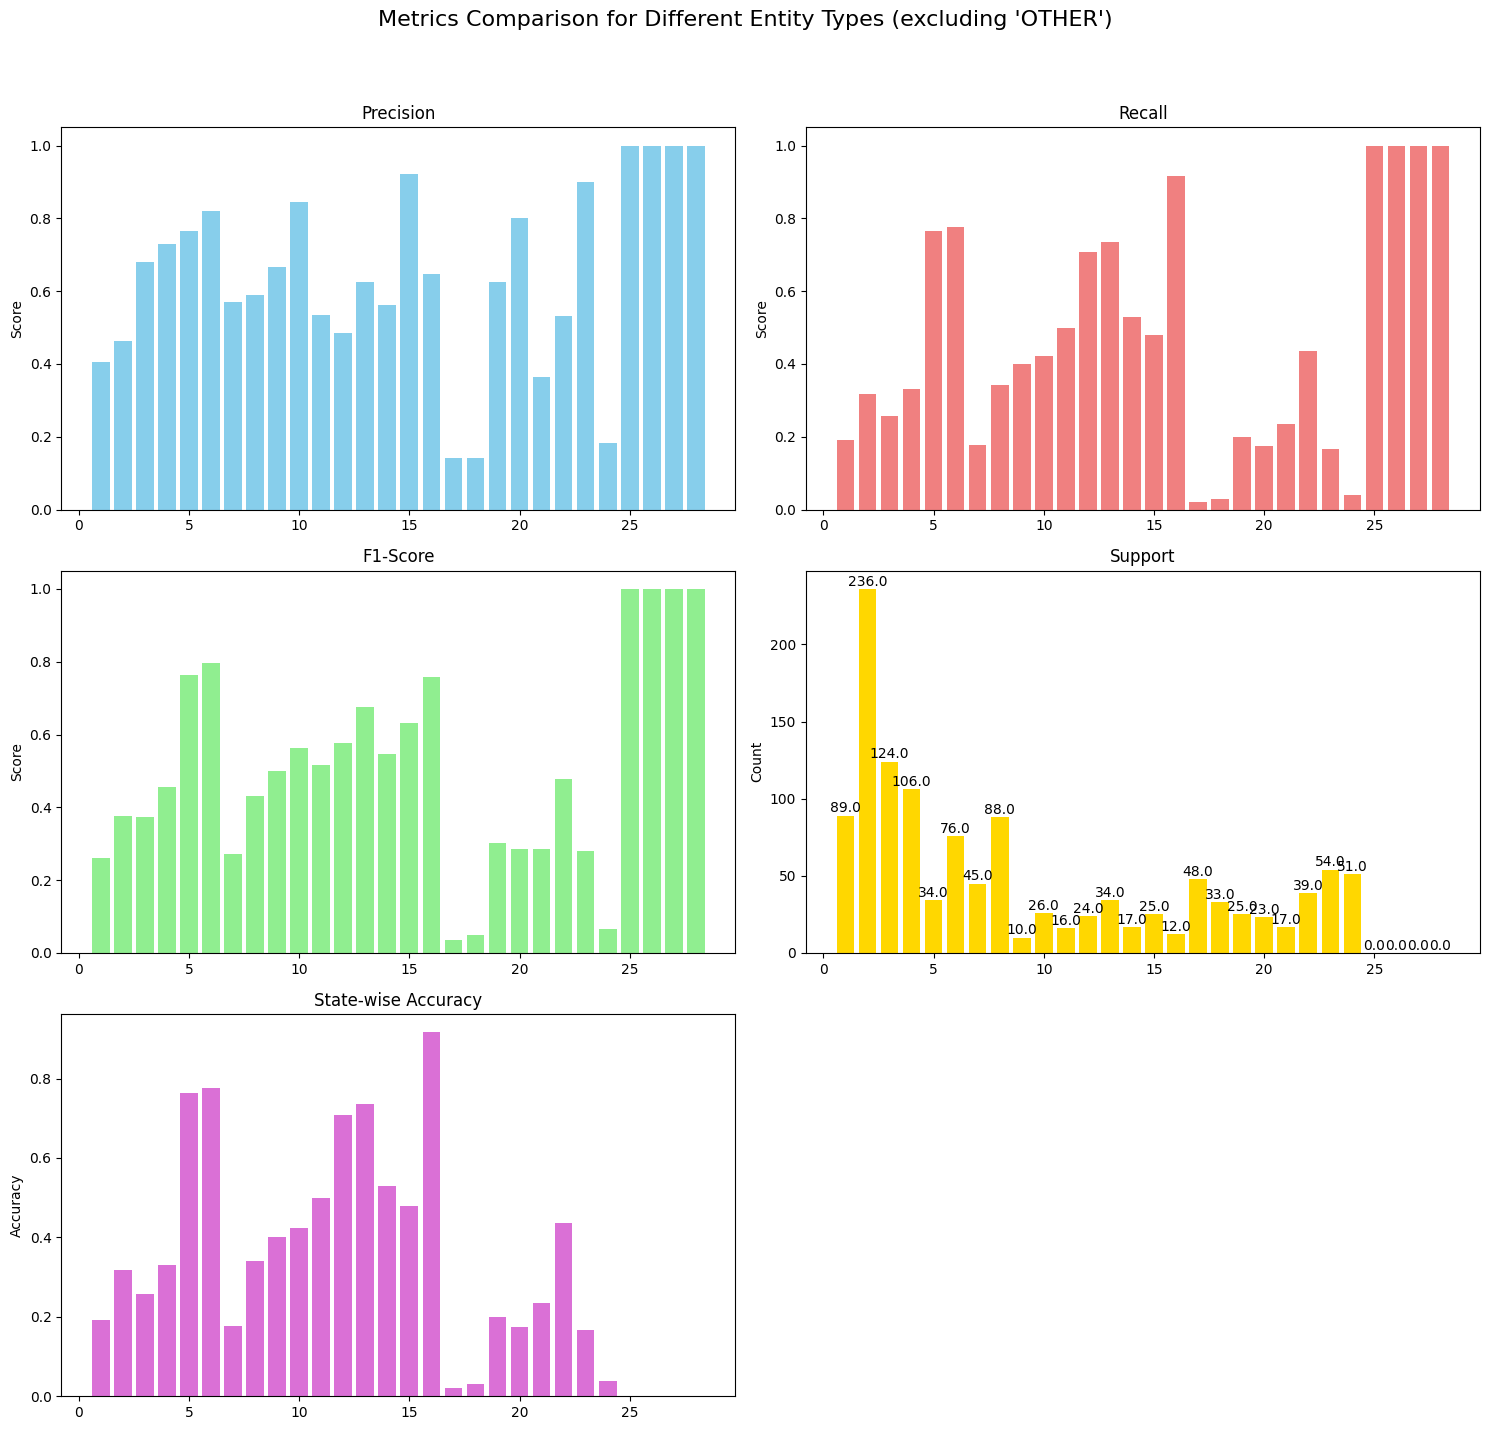


Confusion Matrix (excluding 'OTHER'):


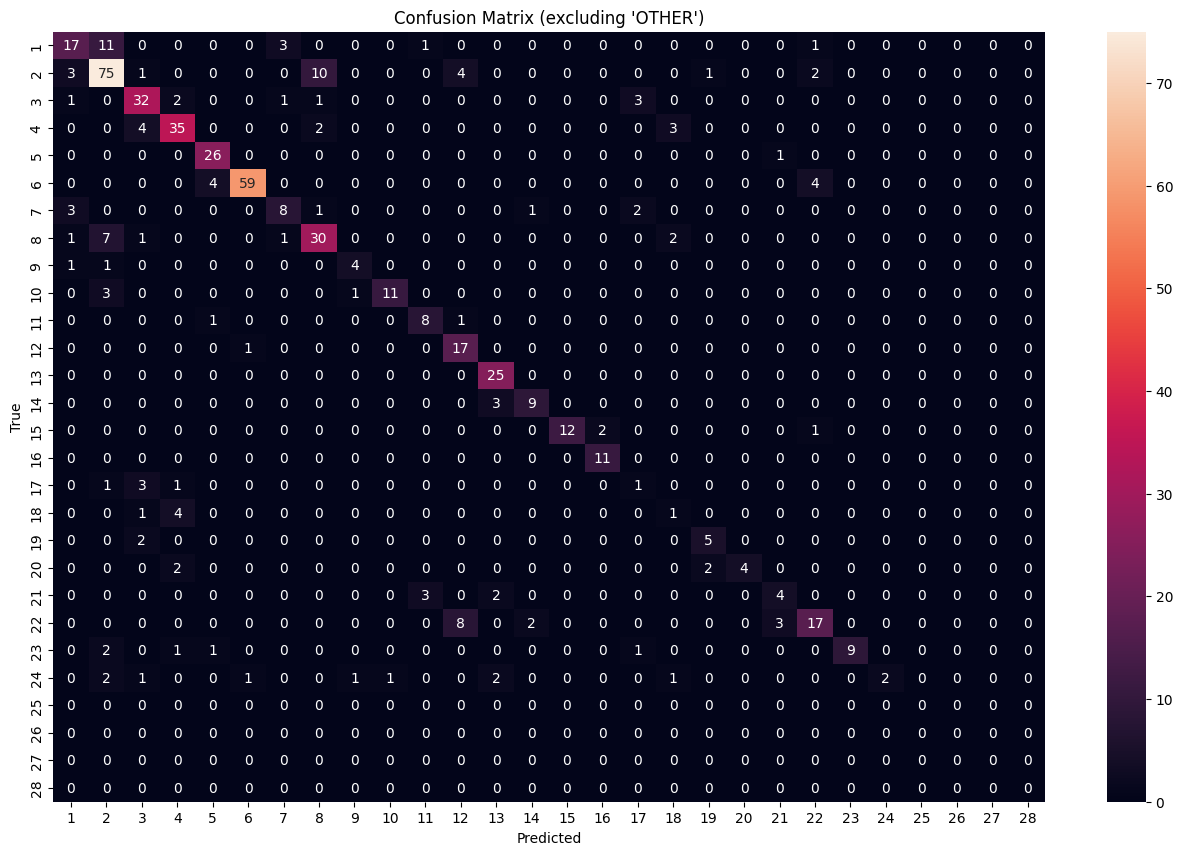

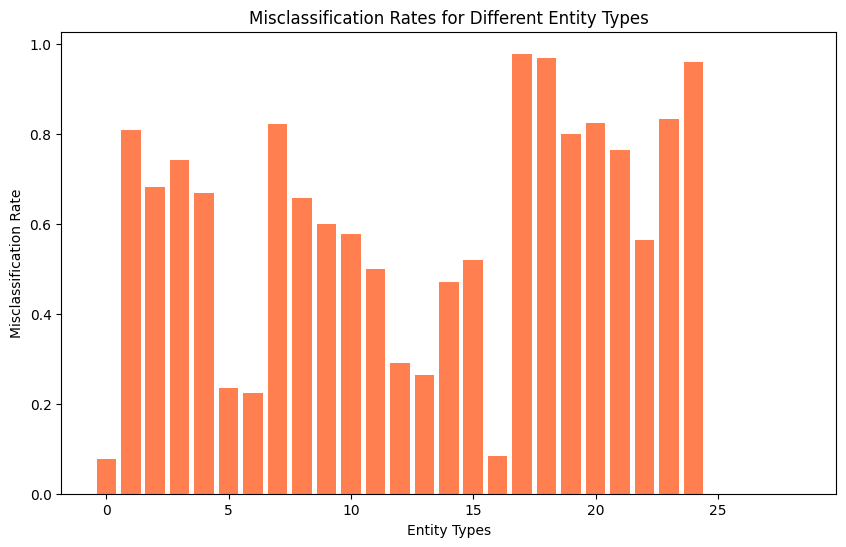

In [56]:
hmm_model_ai, N_test_ai, test_tokens_ai, test_ner_tags_ai, states  = get_hmm_model(df_train_lit, test_lit)
evaluate_model(hmm_model_ai, test_ner_tags_ai, test_tokens_ai, N_test_ai, np.arange(len(ner_tags)))

## Music Data

In [51]:
df_train_music = pd.read_csv('../cross_domain/music/music_train.csv' , converters={'tokens': ast.literal_eval, 'ner_tags': ast.literal_eval})
test_music = pd.read_csv('../cross_domain/music/music_test.csv')

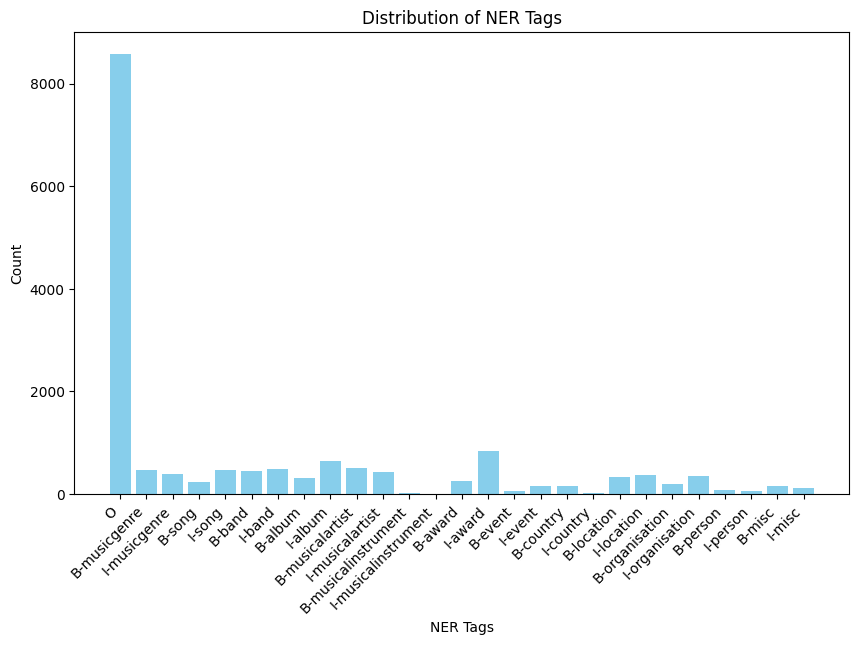

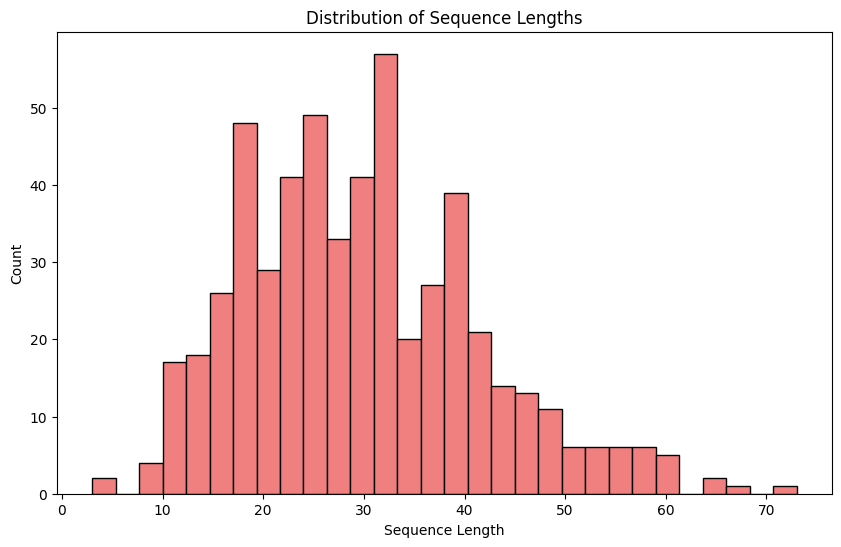

Number of unique tokens: 4139


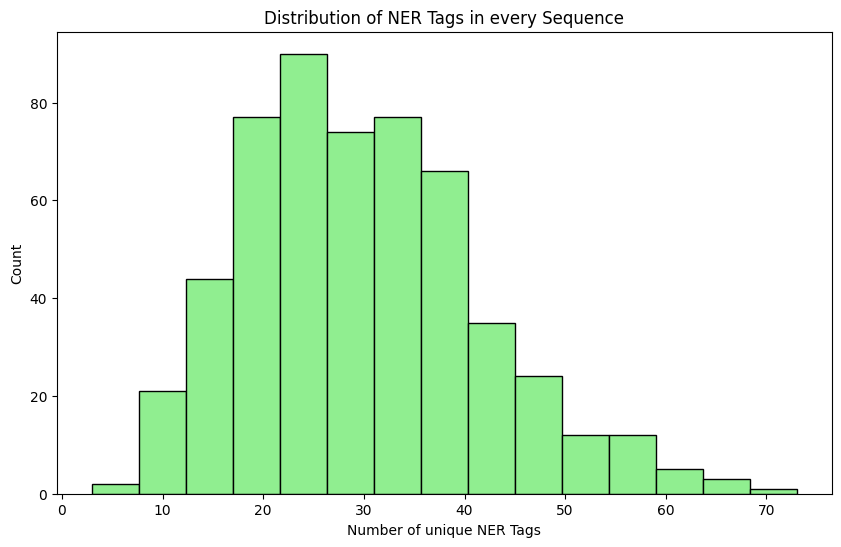

In [52]:
ner_tags = ['O', 'B-musicgenre', 'I-musicgenre', 'B-song', 'I-song', 'B-band', 'I-band', 'B-album', 'I-album', 'B-musicalartist', 'I-musicalartist', 'B-musicalinstrument', 'I-musicalinstrument', 'B-award', 'I-award', 'B-event', 'I-event', 'B-country', 'I-country', 'B-location', 'I-location', 'B-organisation', 'I-organisation', 'B-person', 'I-person', 'B-misc', 'I-misc']
ner_distribution_dict = {i: 0 for i in range(len(ner_tags))}

ner_distribution = df_train_music['ner_tags'].explode().value_counts().sort_index()
ner_distribution_dict.update(ner_distribution)
ner_distribution = pd.Series(ner_distribution_dict)


plt.figure(figsize=(10, 6))
plt.bar(ner_tags, ner_distribution, color='skyblue')
plt.title('Distribution of NER Tags')
plt.xticks(rotation=45, ha='right')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.show()

df_train_science['sequence_length'] = df_train_science['tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df_train_science['sequence_length'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

unique_tokens_distribution = df_train_science['tokens'].explode().nunique()
print(f"Number of unique tokens: {unique_tokens_distribution}")

ner_per_sequence_distribution = df_train_science['ner_tags'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(ner_per_sequence_distribution, bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of NER Tags in every Sequence')
plt.xlabel('Number of unique NER Tags')
plt.ylabel('Count')
plt.show()


Overall Metrics (excluding 'OTHER'):
Accuracy: 0.7180834621329212
              precision    recall  f1-score   support

           1       0.74      0.75      0.74        87
           2       0.71      0.86      0.77        76
           3       0.21      0.11      0.15        27
           4       0.32      0.45      0.37        42
           5       0.73      0.23      0.34       120
           6       0.74      0.30      0.43       129
           7       0.19      0.03      0.06        87
           8       0.38      0.15      0.22       172
           9       0.75      0.42      0.54       101
          10       0.79      0.58      0.67        78
          11       1.00      0.00      0.00         1
          12       1.00      0.00      0.00         3
          13       0.77      0.83      0.80        69
          14       0.84      0.90      0.87       237
          15       0.40      0.17      0.24        12
          16       0.80      0.35      0.49        34
          17  

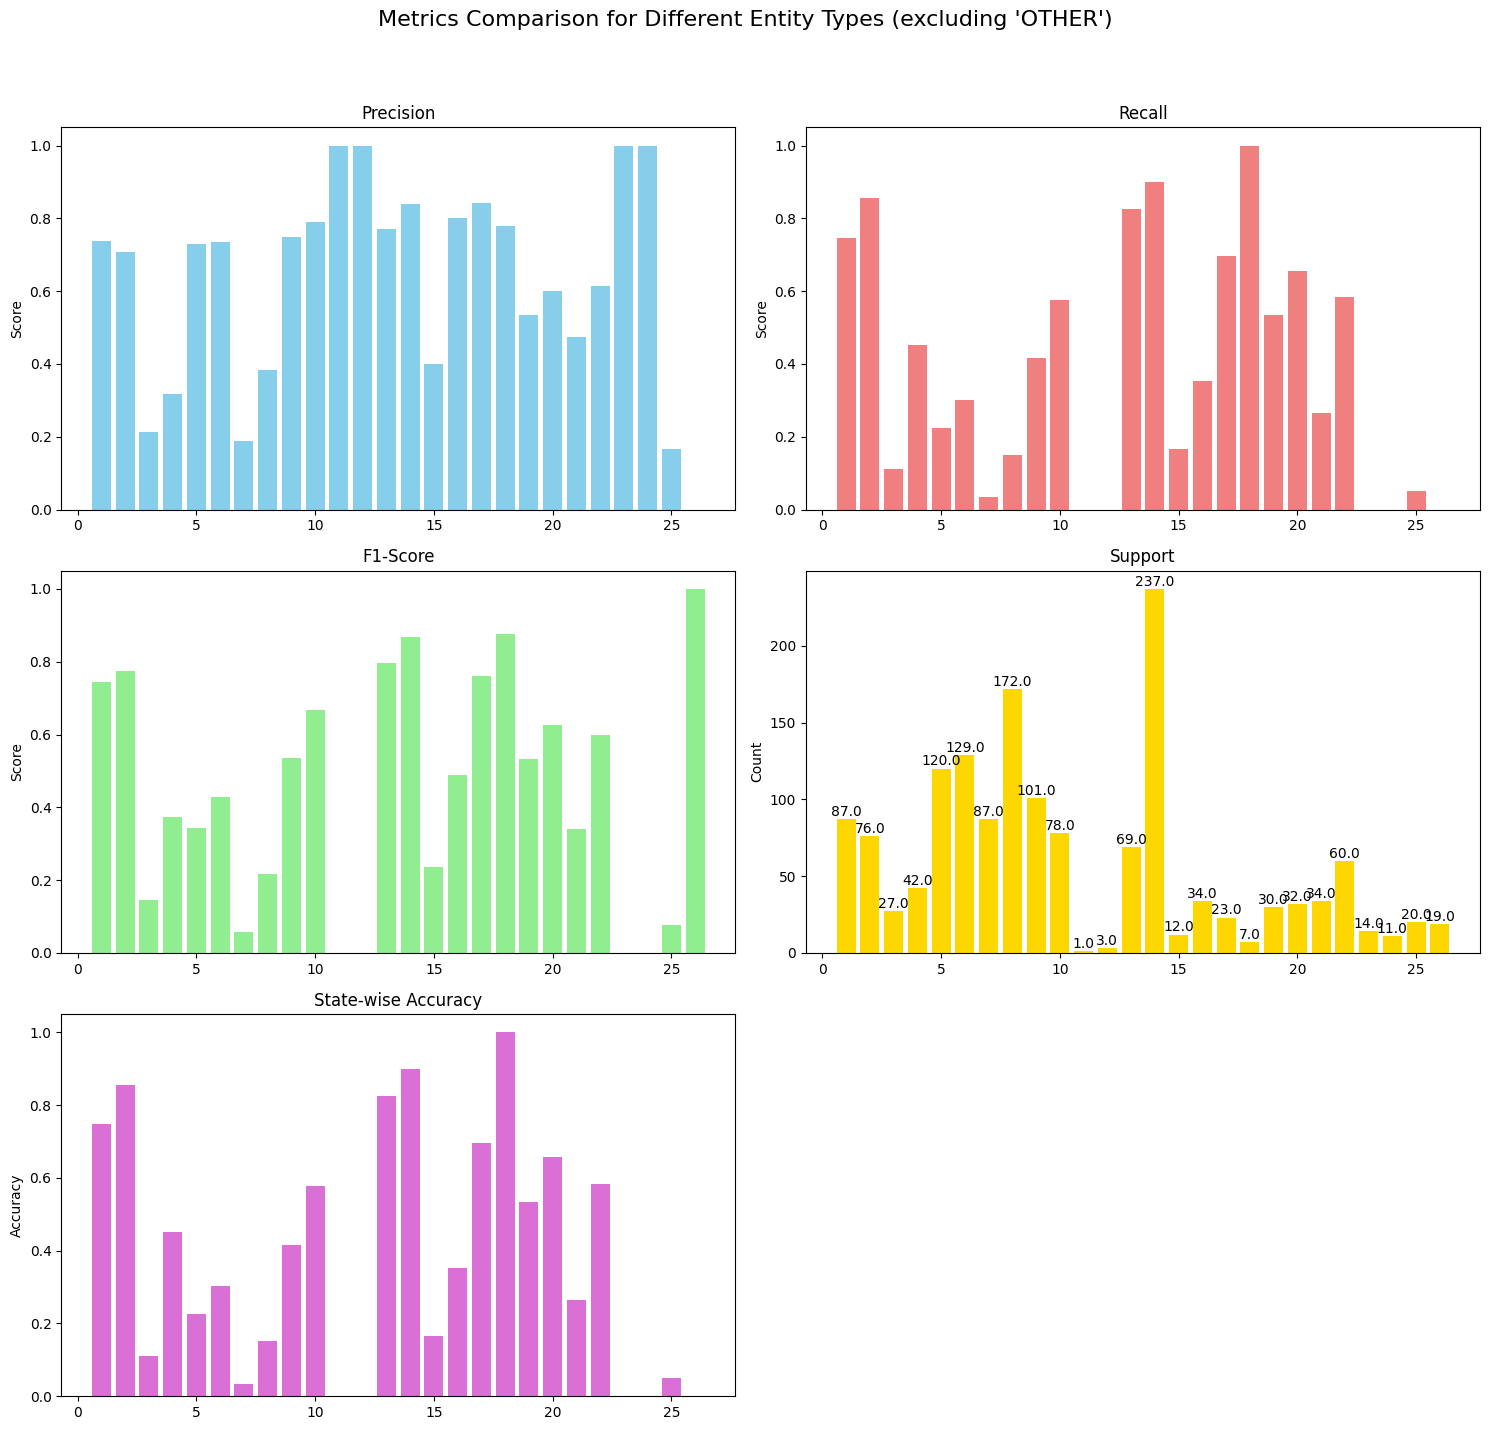


Confusion Matrix (excluding 'OTHER'):


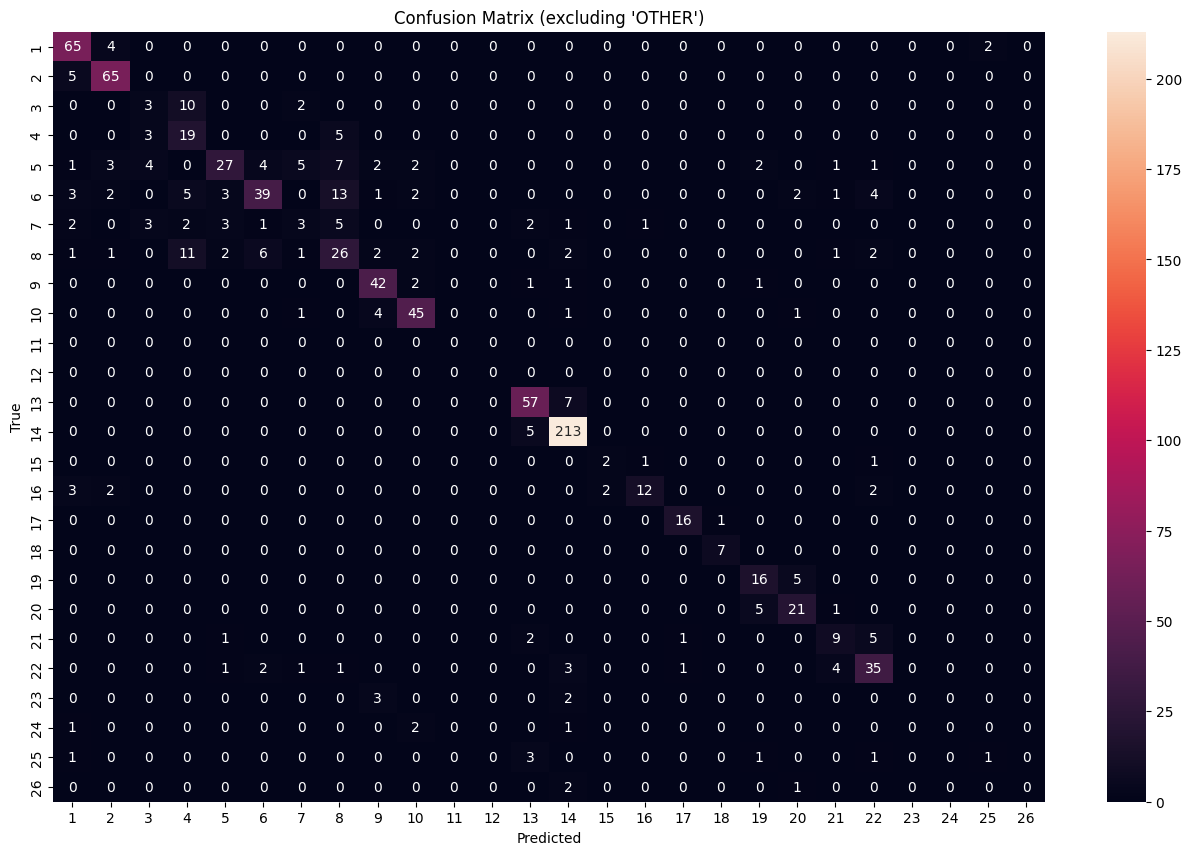

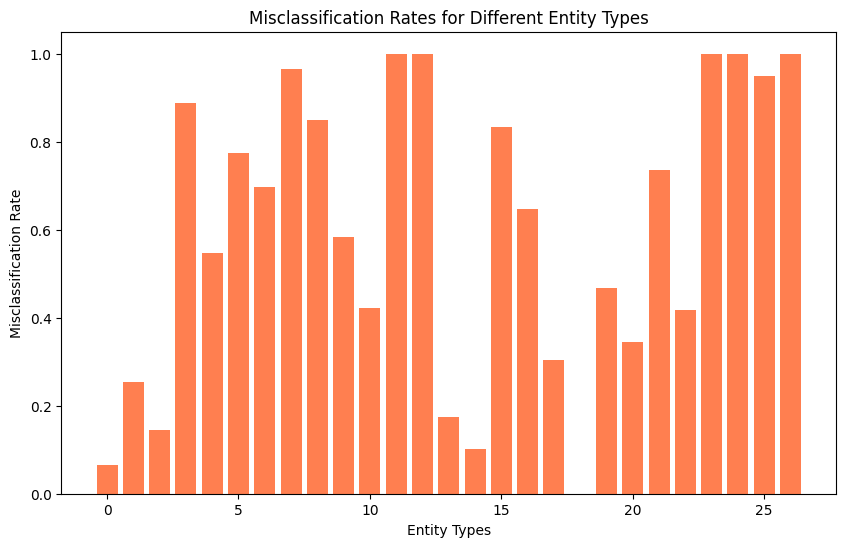

In [53]:
hmm_model_music, N_test_music, test_tokens_music, test_ner_tags_music, states  = get_hmm_model(df_train_music, test_music)
evaluate_model(hmm_model_music, test_ner_tags_music, test_tokens_music, N_test_music, np.arange(len(ner_tags)))

## Politics Dataset

In [41]:
df_train_politics = pd.read_csv('../cross_domain/politics/politics_train.csv' , converters={'tokens': ast.literal_eval, 'ner_tags': ast.literal_eval})
test_politics = pd.read_csv('../cross_domain/politics/politics_test.csv')

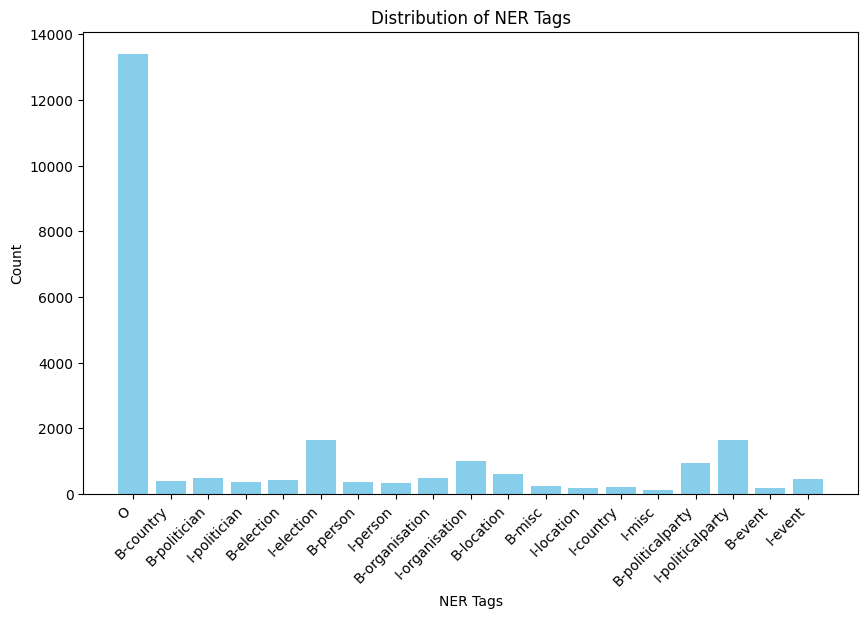

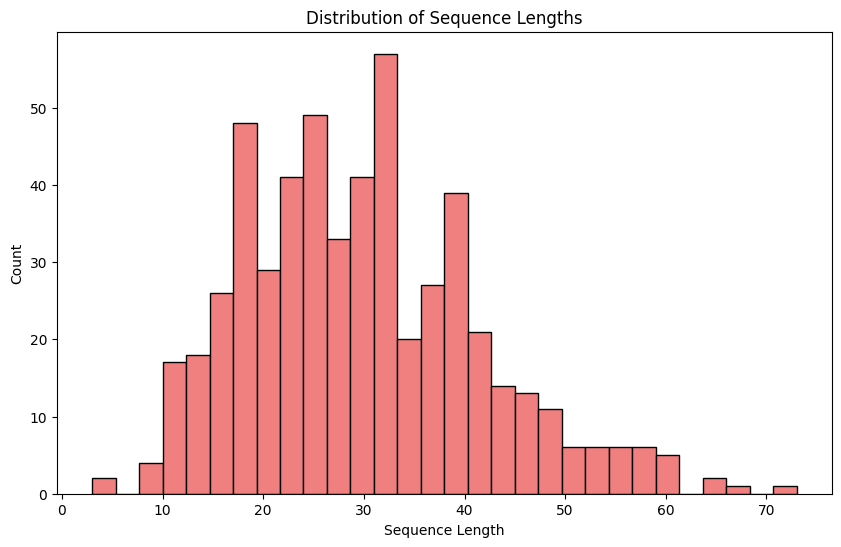

Number of unique tokens: 4139


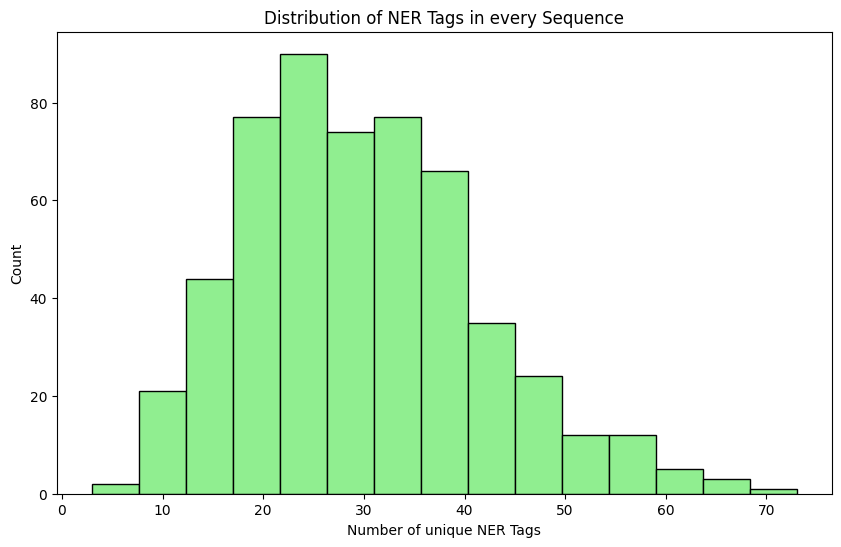

In [42]:
ner_tags = ['O', 'B-country', 'B-politician', 'I-politician', 'B-election', 'I-election', 'B-person', 'I-person', 'B-organisation', 'I-organisation', 'B-location', 'B-misc', 'I-location', 'I-country', 'I-misc', 'B-politicalparty', 'I-politicalparty', 'B-event', 'I-event']
ner_distribution_dict = {i: 0 for i in range(len(ner_tags))}

ner_distribution = df_train_politics['ner_tags'].explode().value_counts().sort_index()
ner_distribution_dict.update(ner_distribution)
ner_distribution = pd.Series(ner_distribution_dict)


plt.figure(figsize=(10, 6))
plt.bar(ner_tags, ner_distribution, color='skyblue')
plt.title('Distribution of NER Tags')
plt.xticks(rotation=45, ha='right')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.show()

df_train_science['sequence_length'] = df_train_science['tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df_train_science['sequence_length'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

unique_tokens_distribution = df_train_science['tokens'].explode().nunique()
print(f"Number of unique tokens: {unique_tokens_distribution}")

ner_per_sequence_distribution = df_train_science['ner_tags'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(ner_per_sequence_distribution, bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of NER Tags in every Sequence')
plt.xlabel('Number of unique NER Tags')
plt.ylabel('Count')
plt.show()


Overall Metrics (excluding 'OTHER'):
Accuracy: 0.7443661971830986
              precision    recall  f1-score   support

           1       0.50      0.36      0.42        56
           2       0.85      0.23      0.36       358
           3       0.88      0.27      0.41       310
           4       0.76      0.85      0.80       123
           5       0.76      0.93      0.84       461
           6       0.00      0.00      1.00        14
           7       0.00      0.00      1.00         5
           8       0.46      0.26      0.33       147
           9       0.49      0.55      0.52       256
          10       0.88      0.24      0.38       295
          11       0.55      0.15      0.24        78
          12       0.81      0.15      0.25        89
          13       0.19      0.75      0.31         8
          14       0.00      0.00      1.00        40
          15       0.62      0.48      0.54       192
          16       0.67      0.77      0.71       356
          17  

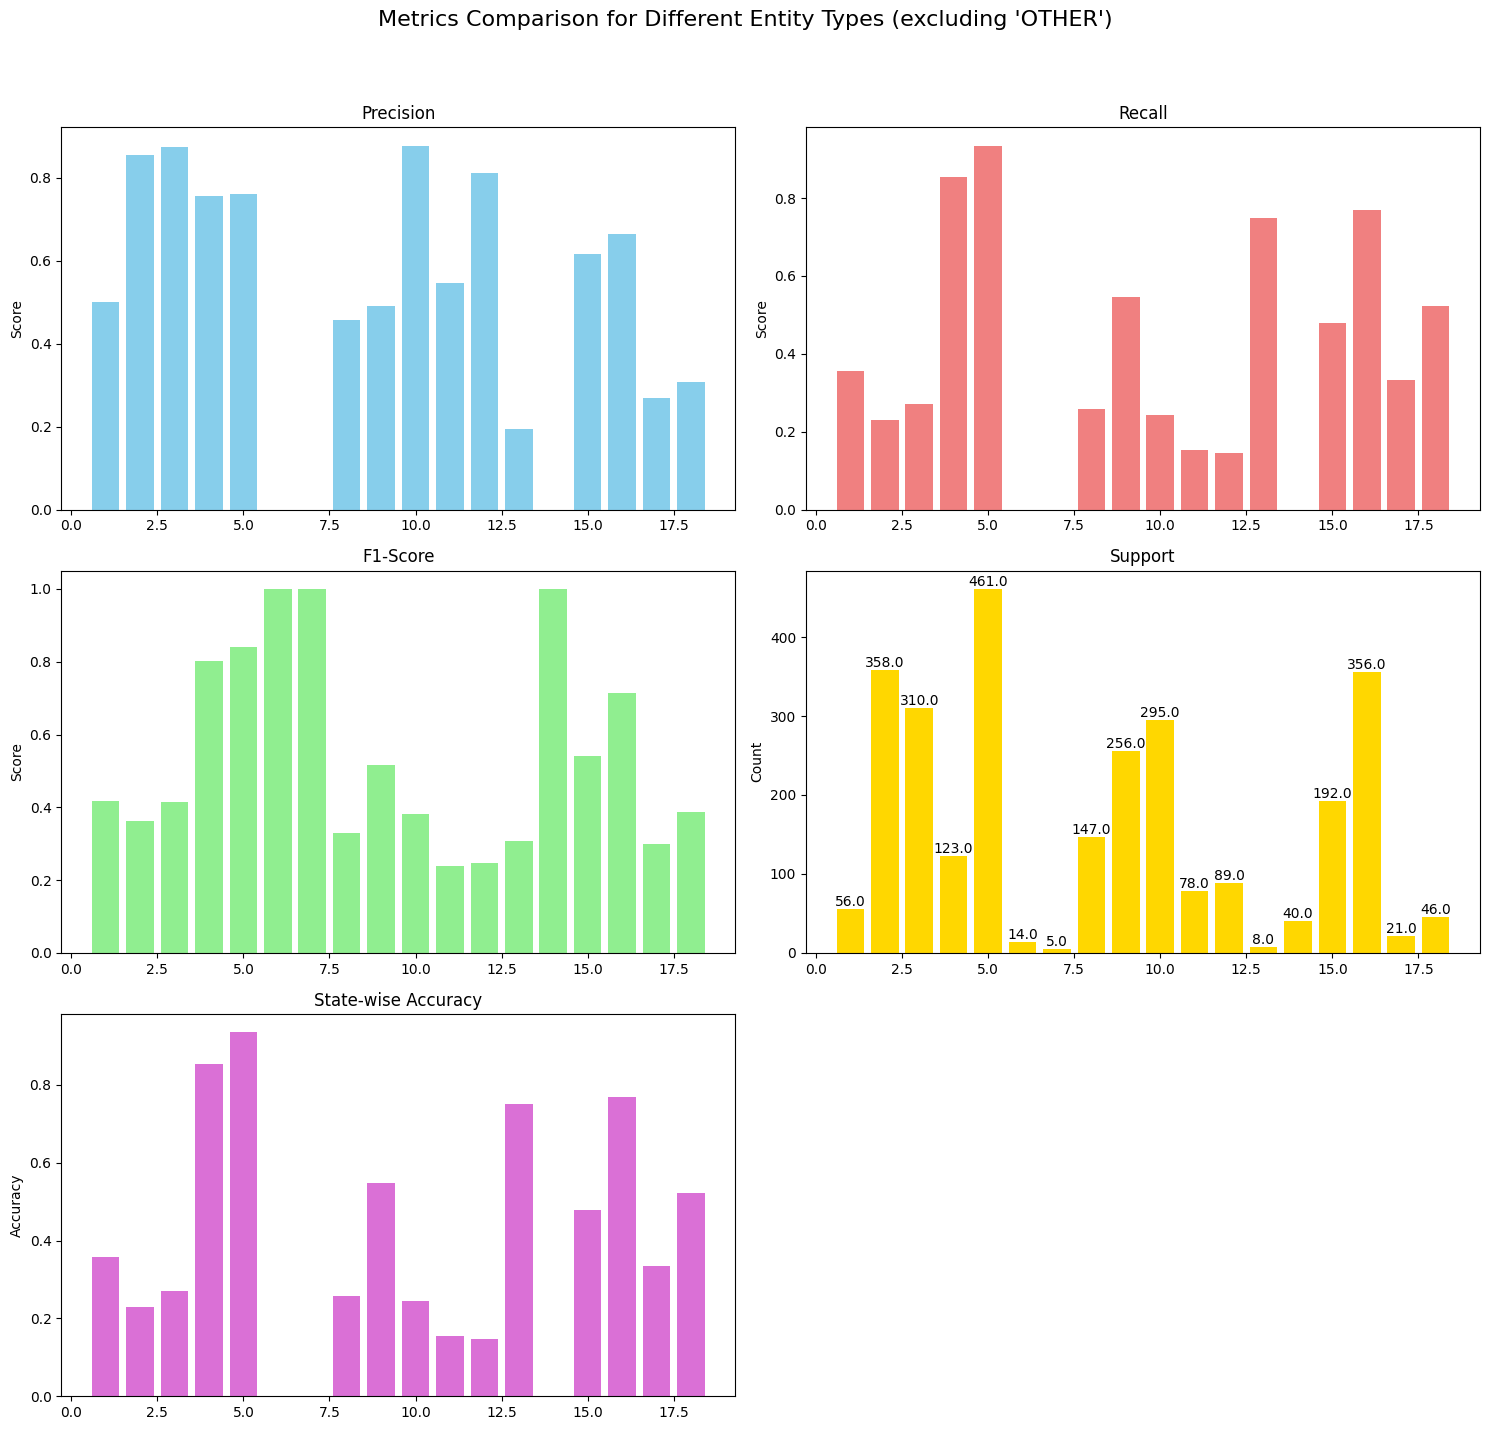


Confusion Matrix (excluding 'OTHER'):


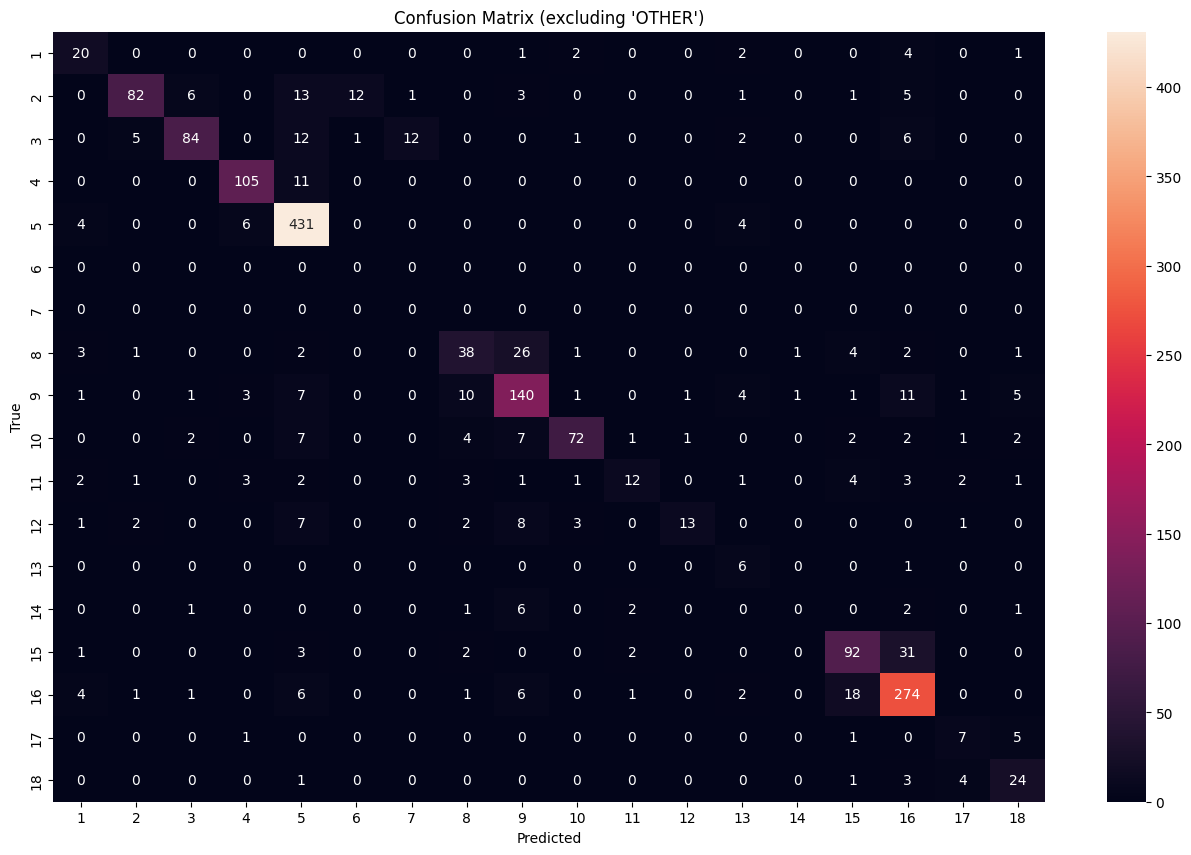

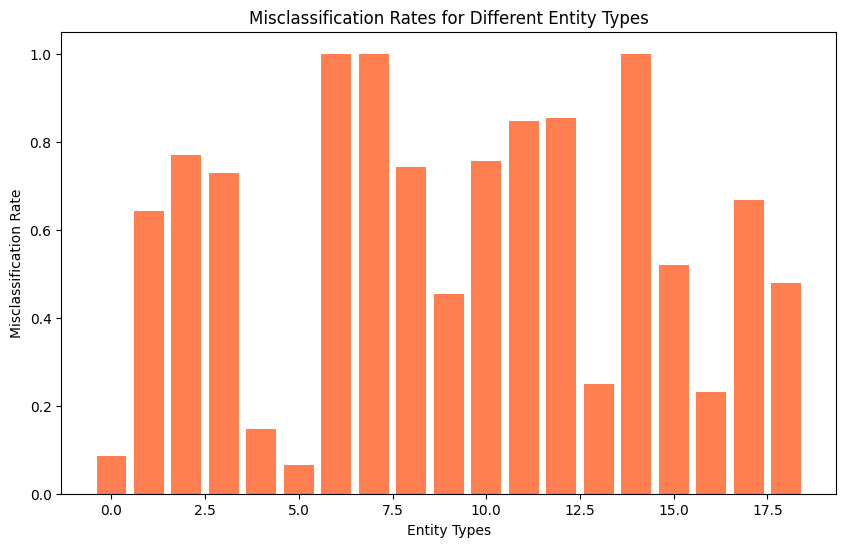

In [49]:
hmm_model_politics, N_test_politics, test_tokens_politics, test_ner_tags_politics, states  = get_hmm_model(df_train_politics, test_politics)
evaluate_model(hmm_model_politics, test_ner_tags_politics, test_tokens_politics, N_test_politics, np.arange(len(ner_tags)))